In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import t
from matplotlib.ticker import MultipleLocator
from scipy.stats import t as t_dist


# Functions

In [2]:
# Funzione gaussiana
def gaussian_offset(x, A, mu, sigma, m, q):
    return A*(1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2)) + m *x +q


In [3]:
def chi_square_func(exp, theo, err, popt):
    dof = len(exp)-len(popt)
    chi = np.sum(((exp-theo)/ err)**2 )
    chi_red = chi/dof
    return chi, chi_red

In [4]:
def fit_func(spectrum, center, dx=15, kev=False, energies=None, plot = True, ax=None):
    center = int(round(center))  # <-- Add this
    if kev:
        
        mask = (energies > center - dx) & (energies < center + dx)
        x_data = energies[mask]
        y_data = spectrum[mask]
    else:
        window = dx       
        x_data = np.arange(center - window, center + window + 1)
        y_data = spectrum[center - window:center + window + 1]


    y_data = [y + 25000 if y == 0 else y for y in y_data]

    

    dof = len(x_data) -5

    err_counts = [np.sqrt(c) if c > 0 else 1 for c in y_data]
    for i in range(len(err_counts)):
        if err_counts[i]==0:
            print(i)

    initial_guess = [max(y_data), center, 5, 0, 10]
    bounds = (
        [0, center - 5, 0.01, -10000, 1],
        [1000* max(y_data), center + 5, 50, 10000, max(y_data)]
    )

    popt, pcov = curve_fit(gaussian_offset, x_data, y_data, sigma=err_counts, p0=initial_guess, bounds=bounds)
    err = np.sqrt(np.diag(pcov))

    if ax is None:
        ax = plt.gca()

    bins = np.linspace(min(x_data), max(x_data), len(x_data)+1)

    if plot:
        
        counts, bin_edges, _ = ax.hist(x_data, bins=bins, weights=y_data,
                                      histtype='step', color = 'black', label='Hist data')
        '''ax.errorbar(x_data, y_data, yerr = err_counts, 
                    markersize = 5,
                    capsize=5,
                    alpha = 0.86,
                    fmt = 'o',
                    color='dimgray',
                   label = 'Data')'''
        
        db = bin_edges[1]-bin_edges[0]
        
        xfit = np.linspace(x_data[0], x_data[-1]+1, 500)
        yfit = gaussian_offset(xfit, *popt)
        ax.plot(xfit, yfit, color='deepskyblue', lw=2, label='Gaussian fit')
        ax.set_xlim(min(x_data), max(x_data))
        if kev:
            dx = 2
            dy = 1
            ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
            ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
            ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
            ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

            ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--', label=f'Peak: {popt[1]:.2f} keV')
            ax.set_xlabel('E [keV]', size = 12)
            ax.set_title(f'Gaussian fit @ {center} keV', size = 15)
            ax.set_ylabel(f'Counts / {db:.1f} keV', size = 12)
        else:

            dx = 10
            dy = 1
            ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
            ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
            ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
            ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

            
            ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--', label=f'Peak: {popt[1]:.2f}')
            ax.set_xlabel('Channel', size = 12)
            ax.set_title(f'Gaussian fit @ {center} chn', size = 15)
            ax.set_ylabel(f'Counts / {db:.0f} chn', size = 12)
        ax.grid(alpha=0.25)
        ax.legend(loc = 'upper left')

    chi, chi_red = chi_square_func(x_data, gaussian_offset(x_data, *popt), err_counts, popt)
     
 #   print(r"$\chi^2$", chi)
 #   print(r'$\chi^2$/ dof', chi_red)
    

    return popt, err, dof




In [5]:
def k_calibration(E_chn, a, b):
    return E_chn * a + b

In [6]:
def t_test_theoretical(x_exp, sigma, x_theo, dof):
    t_stat = (x_exp - x_theo) / sigma
    print(f't = {t_stat:.2f}')
    
    # p-value a due code
    p_value = 2 * t_dist.sf(abs(t_stat), df=dof)

    if p_value < 0.05:
        print('❌ p < 0.05 ')
    else:
        print('✅ p > 0.05 ')
    print(f'p-value = {p_value:.4f}')
    return t_stat, p_value

In [7]:
def fhwm_func(E, a, b):
    return np.sqrt( (a / np.sqrt(E))**2 + b**2)


In [8]:
import numpy as np

def fwhm_percentuale(sigma, delta_sigma, E, delta_E):

    sigma = np.array(sigma)
    delta_sigma = np.array(delta_sigma)
    E = np.array(E)
    delta_E = np.array(delta_E)

    # Calcolo FWHM percentuale: (2.355 * sigma) / E 
    fwhm_perc = (2.355 * sigma / E) 

    # Propagazione dell'errore relativa
    rel_err_sigma = delta_sigma / sigma
    rel_err_E = delta_E / E
    delta_fwhm_perc = fwhm_perc * np.sqrt(rel_err_sigma**2 + rel_err_E**2)

    return fwhm_perc, delta_fwhm_perc


In [9]:
def fit_func_sottratto(spectrum, background, center, dx=50, kev=False, energies=None, ax=None):
    if kev:
        if energies is None:
            raise ValueError("Devi fornire 'energies' se kev=True")
        mask = (energies > center - dx) & (energies < center + dx + 1)
        x_data = energies[mask]
        y_data = spectrum[mask]
        y_bkg = background[mask]
    else:
        window = dx
        x_data = np.arange(center - window, center + window + 1)
        y_data = spectrum[center - window:center + window + 1]
        y_bkg = background[center - window:center + window + 1]

    y_sub = y_data - y_bkg
    y_sub[y_sub < 0] = 0
    
    err_counts = [np.sqrt(d + b) if (d + b) > 0 else 1 for d, b in zip(y_data, y_bkg)]

    valid_mask = y_sub > 0
    x_data = x_data[valid_mask]
    y_sub = y_sub[valid_mask]
    y_sub = [y + 250000 if y == 0 else y for y in y_sub]
    err_counts = np.array(err_counts)[valid_mask]
    dof = len(x_data) -5

    initial_guess = [max(y_sub), center, 5, 0, 1100]
    bounds = (
        [0, center - 1, 0.01, -1000, 0],
        [1000 * max(y_sub), center + 1, 25, 1000, np.inf]
    )

    popt, pcov = curve_fit(gaussian_offset, x_data, y_sub, sigma=err_counts, p0=initial_guess, bounds=bounds)
    err = np.sqrt(np.diag(pcov))

    if ax is None:
        ax = plt.gca()
    bins = np.linspace(min(x_data), max(x_data), len(x_data)+1)
    counts, bin_edges, _ = ax.hist(x_data, bins=bins, weights=y_sub,
                                   histtype='step', color='black', label='Hist data')
    '''
    ax.errorbar(x_data, y_sub, yerr=err_counts,
                markersize=5,
                capsize=5,
                alpha=0.86,
                fmt='o',
                color='dimgray',
                label='Data')
    '''
    xfit = np.linspace(min(x_data), max(x_data), 500)
    yfit = gaussian_offset(xfit, *popt)
    ax.plot(xfit, yfit, color='deepskyblue', lw=2, label='Gaussian fit')
    ax.set_xlim(min(x_data), max(x_data))

    ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--',
              label=f'Peak: {popt[1]:.2f} {"keV" if kev else ""}')

    # Label e titolo coerenti con fit_func
    if kev:
        ax.set_xlabel('E [keV]', size=12)
        ax.set_title(f'Gaussian fit @ {center} keV', size=15)
    else:
        ax.set_xlabel('Channel', size=12)
        ax.set_title(f'Gaussian fit @ {center} chn', size=15)

    ax.set_ylabel('Counts', size=12)
    ax.grid(alpha=0.25)
    ax.legend()

    return popt, err, dof


In [10]:
def get_eff_value(energia, x_eff, eff_value):
    idx = np.abs(x_eff - energia).argmin()
    return eff_value[idx]

# Background

In [11]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_bkg = data[0].values

# correggo col dead time il background---> lo faccio subito in modod talr da avere già lo sesso spettro corretto ed avere la stessa risoluszione enrgetica. il dead time peggior la risoluzione
t_live_b = 76747
t_real_b = 76752
# correggo subito per il tempo morto
D_b = 1-(t_live_b/t_real_b)

spectrum_bkg = spectrum_bkg/D_b
spectrum_bkg[spectrum_bkg < 0] = 0 


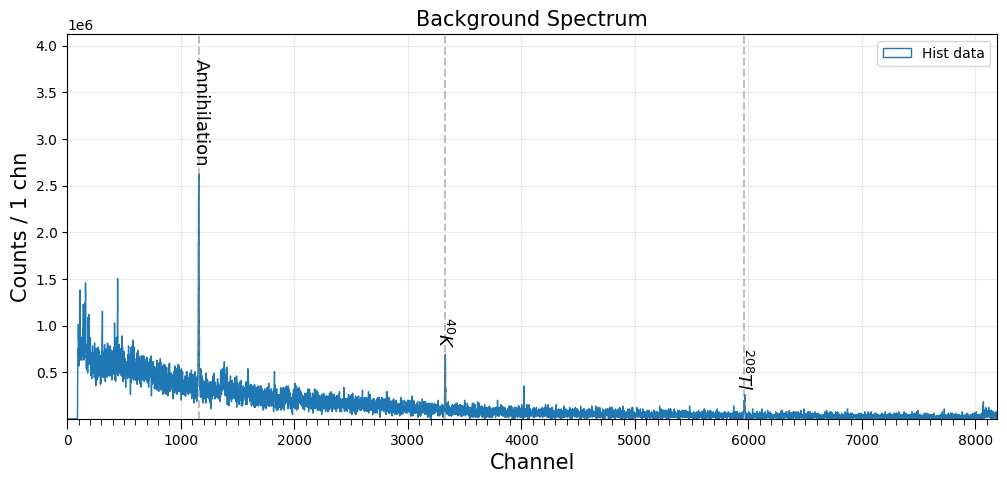

In [13]:
plt.figure(figsize=(12, 5))

# === IMPOSTA TICKS X PRIMA DEL PLOT ===
dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero


chn = np.arange(len(spectrum_bkg))  # canali da 0 a N-1
#plt.bar(chn, spectrum_bkg, width=1.0, label='Spectrum')
#plt.plot(spectrum_bkg, lw = 0.5, label='Spectrum')
bins = np.linspace(min(chn), max(chn), len(chn)+1)
counts, bin_edges, _ = plt.hist(chn, bins=bins, weights=spectrum_bkg,
                                      histtype='step', label='Hist data')

db = bin_edges[1]-bin_edges[0]
plt.xlabel('Channel', size = 15)
plt.ylabel(f'Counts / {db:.0f} chn', size = 15)
plt.title('Background Spectrum', size = 15)
plt.text(1100,  2.75e6, "Annihilation", rotation=270,  size = 13)
plt.text(3229 , 0.8e6, r'$^{40}K$', rotation=270,  size = 13)
plt.text(5865 , 0.35e6, r'$^{208}Tl$', rotation=270,  size = 13)
plt.vlines(1157,  0, max(spectrum_bkg)+ 1500000 , color = 'grey', alpha = 0.5, ls = '--')
plt.vlines(3329,  0, max(spectrum_bkg)+ 1500000 , color = 'grey', alpha = 0.5, ls = '--')
plt.vlines(5965,  0, max(spectrum_bkg)+ 1500000 , color = 'grey', alpha = 0.5, ls = '--')
plt.xlim(0, len(spectrum_bkg))
plt.ylim(1,max(spectrum_bkg)+ 1500000)
plt.legend()
plt.grid(alpha = 0.25)
plt.savefig("new image/ HPGe background", dpi=300, bbox_inches='tight')

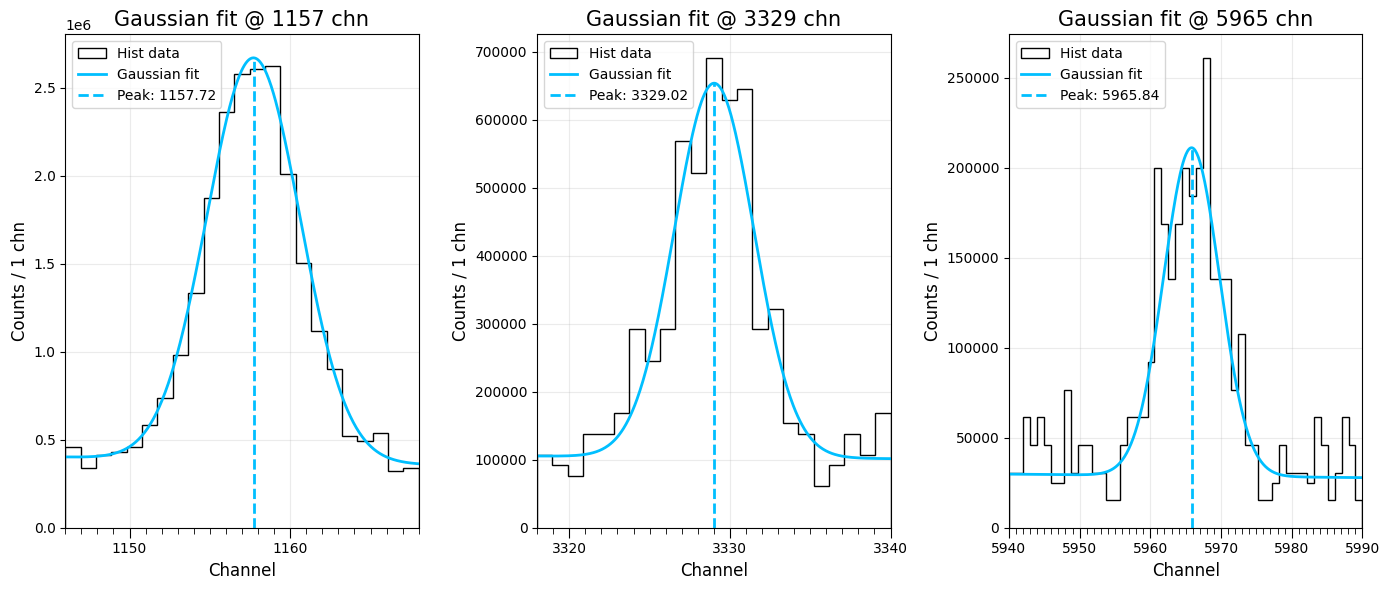

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))  # 1 riga, 3 colonne

E_chn = [1157, 3329, 5965] 
popt_chn = []
popt_chn_err = []

for i, e in enumerate(E_chn):
    dx = 25 if e == E_chn[-1] else 11
    popt, err, _ = fit_func(spectrum_bkg, e, dx=dx, ax=axes[i])
    popt_chn.append(popt)
    popt_chn_err.append(err)

popt_chn = np.vstack(popt_chn)

popt_chn_err = np.vstack(popt_chn_err)
plt.savefig("new image/ chn_bkg_peaks", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [15]:
popt_chn

array([[ 1.66677482e+07,  1.15771829e+03,  2.90176865e+00,
        -1.93928868e+03,  2.62491840e+06],
       [ 3.42241170e+06,  3.32902159e+03,  2.48294457e+00,
        -1.76375178e+02,  6.90768000e+05],
       [ 1.80932151e+06,  5.96584198e+03,  3.96130776e+00,
        -3.89105852e+01,  2.60956800e+05]])

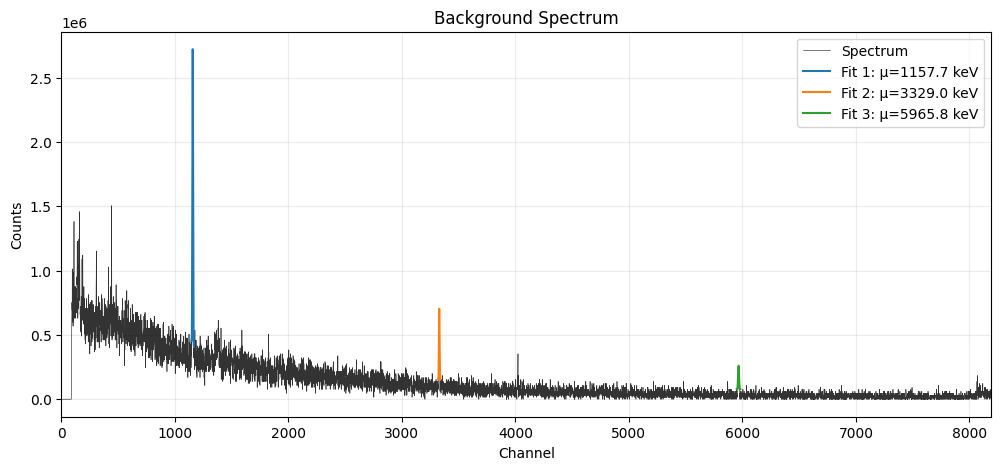

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(spectrum_bkg, color = 'black', lw = 0.46, alpha = 0.8, label='Spectrum')
for i, popt in enumerate(popt_chn):
    A, mu, sigma, m, q = popt
    x_fit = np.linspace(mu - 4*sigma, mu + 4*sigma, 300)
    y_fit = gaussian_offset(x_fit, A, mu, sigma,m, q+50000)
    plt.plot(x_fit, y_fit,  label=f'Fit {i+1}: μ={mu:.1f} keV')


plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Background Spectrum')
plt.xlim(0, len(spectrum_bkg))
#plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.show()

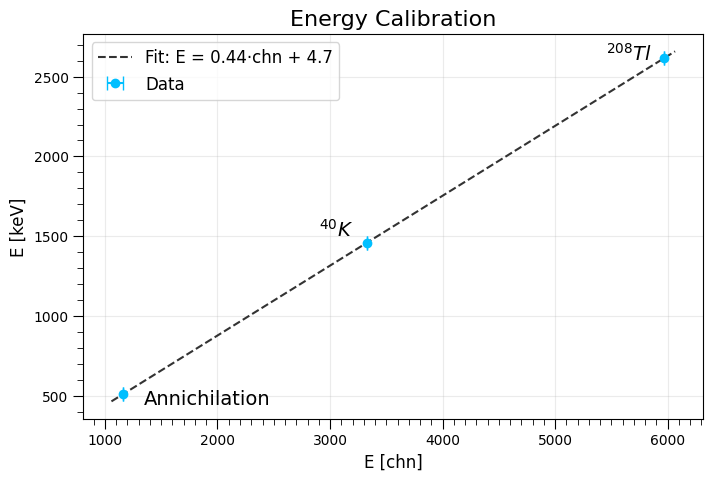

In [20]:
E_kev = [511, 1460.830, 2614] #kev

plt.figure(figsize=(8, 5))


dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

dx = 500
dy = 100
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.yaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='y', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='y', which='minor', length=4, labelsize=0)   # tacche piccole, no numero



plt.errorbar( popt_chn[:,1],E_kev, xerr=popt_chn_err[:,1], fmt='o', color = 'deepskyblue', capsize=5, label='Data')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, popt_chn[:,1], E_kev, p0=p0 )
# Incertezze
perr = np.sqrt(np.diag(pcov))
a_bkg = popt[0]
b_bkg = popt[1]

# Plot
x_fit = np.linspace(min(popt_chn[:,1])-100, max(popt_chn[:,1])+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)
plt.text(1350 , 450, "Annichilation", rotation=0,  size = 14)
plt.text(2900 , 1500, r'$^{40}K$', rotation=0,  size = 14)
plt.text(5450 , 2600, r'$^{208}Tl$', rotation=0,  size = 14)
plt.legend(fontsize = 12)
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("new image/ E_cal_bkg", dpi=300, bbox_inches='tight')

In [21]:
##### print(a_bkg , '+/-', perr[0])
print(b_bkg , '+/-', perr[1])

4.682979221543532 +/- 0.1293382938289162


In [22]:
channels_bkg = np.arange(len(spectrum_bkg))         # x originale
energies_bkg = a_bkg * channels_bkg + b_bkg  
energies_bkg_err = np.sqrt(np.diag(pcov))[0]*channels_bkg + np.sqrt(np.diag(pcov))[1]

In [23]:
b_bkg

np.float64(4.682979221543532)

In [24]:
energies_bkg[1]-energies_bkg[0]

np.float64(0.4373829474144024)

In [25]:
mask = (energies_bkg > 0) & (energies_bkg < 3000)
spectr_3Mev = spectrum_bkg[mask]

print(np.sum(spectr_3Mev))
print('attività grezza', np.sum(spectr_3Mev)/(t_real_b), 'cps')

1186017955.1992645
attività grezza 15452.599999990418 cps


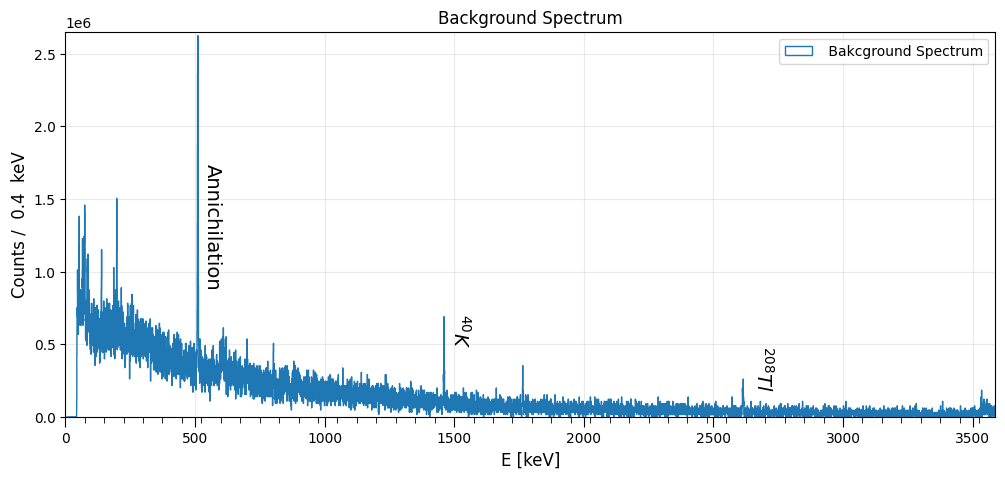

In [27]:
plt.figure(figsize=(12,5))

dx = 500
dy = 75
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




bins = np.linspace(min(energies_bkg), max(energies_bkg), len(energies_bkg))
counts, bin_edge, _ = plt.hist(energies_bkg, bins = bins, weights = spectrum_bkg, lw = 0.5,  histtype='step',label=' Bakcground Spectrum')
db = bin_edge[1]- bin_edge[0]
plt.xlabel('E [keV]', size = 12)
plt.ylabel(f'Counts / {db: .1f}  keV', size = 12)
plt.title('Background Spectrum')
plt.xlim(0, max(energies_bkg))
plt.ylim(0, max(spectrum_bkg)+25000)
plt.text(530 , 0.9e6, "Annichilation", rotation=270,  size = 14)
plt.text(1480 , 0.5e6, r'$^{40}K$', rotation=270,  size = 14)
plt.text(2650 , 0.2e6, r'$^{208}Tl$', rotation=270,  size = 14)
plt.savefig("HPGe images/ spectrum_bkg_kev", dpi=300, bbox_inches='tight')
plt.legend(loc = 'upper right')
plt.grid(alpha = 0.25)
plt.savefig("new image/bkg_spectrum_kev", dpi=300, bbox_inches='tight')

In [28]:
for i in range(0,len(energies_bkg)):
    if spectrum_bkg[i] != 0:
        print(f' Energy threshold at {energies_bkg[i] + 15 : .2f} keV' )
        break

 Energy threshold at  58.61 keV


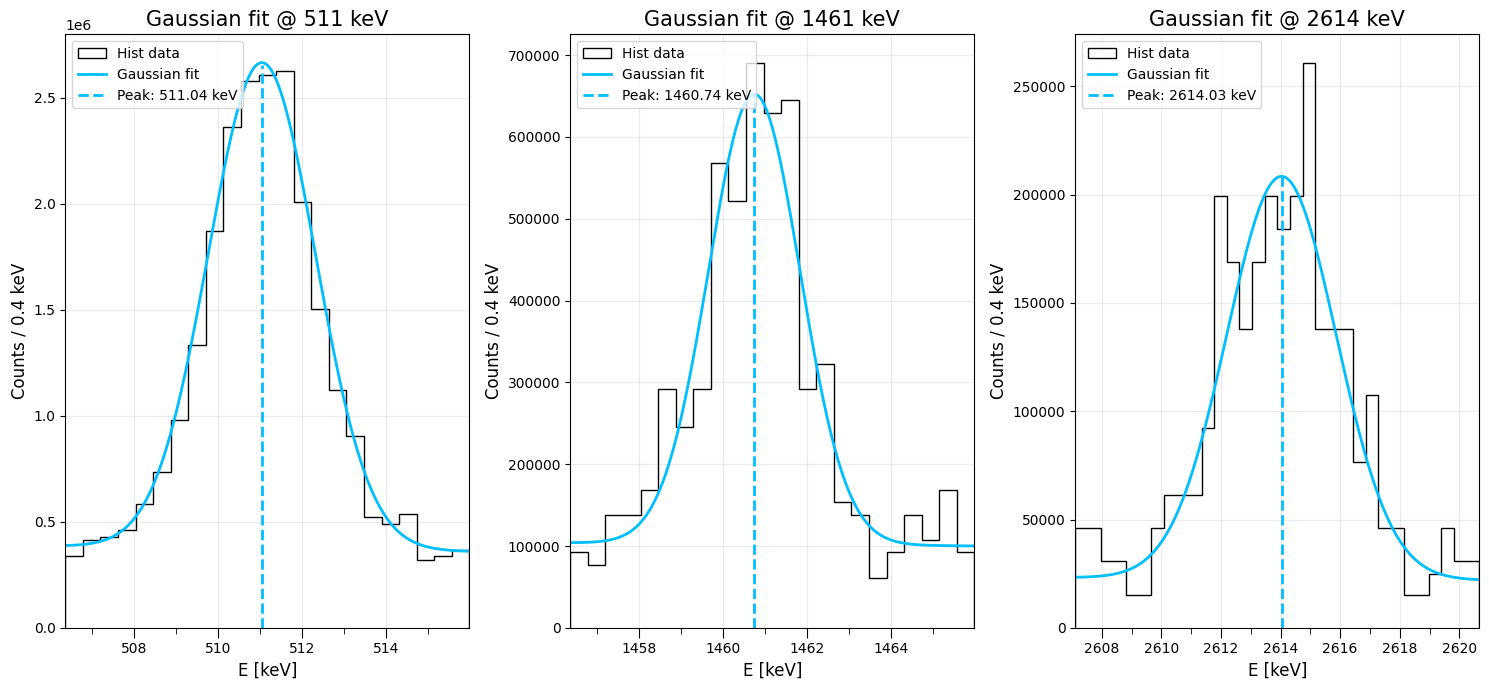

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))  # 1 riga, 3 colonne
E_kev = np.sort([ 511, 1460.83, 2614 ]) #kev
popt_kev = []
popt_kev_err = []
dofs = []
for i, e in enumerate(E_kev):
    if e == 2614:
        dx = 7
    else:
        dx = 5
    popt, err, dof = fit_func( spectrum_bkg, e, dx = dx, kev = True, energies = energies_bkg, ax=axes[i])
    popt_kev.append(popt)
    popt_kev_err.append(err)
    dofs.append(dof)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)
#dofs = np.vstack(dofs)

plt.tight_layout()
plt.savefig("new image/energy_peak_fit_bkg", dpi=300, bbox_inches='tight')
plt.show()


In [30]:
dofs 

[18, 18, 27]

In [31]:
for i in range(0, len(popt_kev[:,1])):
    mu_kev = popt_kev[:,1]
    mu_kev_err = popt_kev_err[:,1]
    mu_theo = E_kev[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo, dof = dofs[i])
    

t = 1.35
✅ p > 0.05 
p-value = 0.1944
t = -0.90
✅ p > 0.05 
p-value = 0.3794
t = 0.21
✅ p > 0.05 
p-value = 0.8364


incertezza grandi solo 3 punti del fit
paramters: [1.13071735e-01 3.61058237e-25]
Errori: [4.68431771e-02 5.71538162e+02]


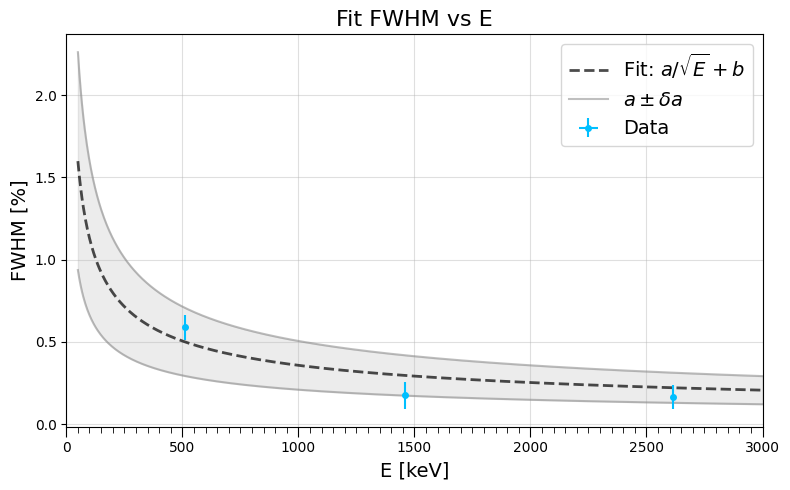

In [33]:
# Calcolo FWHM e incertezza
sigma= popt_kev[:,2]
sigma_err_kev=popt_kev_err[:,2]
mu_kev=popt_kev[:,1]
mu_kev_err =popt_kev_err[:,1]
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,100])
p0=[3,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma= FWHM_err, p0=p0, bounds=boundary)
perr_back_res = np.sqrt(np.diag(pcov))
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))

dx = 500
dy = 50
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero





plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, *popt)*100, label=r'Fit: $a/\sqrt{E} + b$',  color='black', ls = '--', alpha = 0.7, lw=2)

upper_curve = fhwm_func(E_fit, popt[0] + perr_back_res[0], popt[1]) * 100
lower_curve = fhwm_func(E_fit, popt[0] - perr_back_res[0], popt[1]) * 100

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.5, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.5)

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*5*100,
             fmt='o',  
             color = 'deepskyblue', 
             markersize=4,               # dimensione punto
             label='Data')

a_res_bkg = popt[0]
b_res_bkg  = popt[1]

# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.xlim(0, 3000)
plt.title('Fit FWHM vs E',  size = 16)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig("new image/FWHM_bkg", dpi=300, bbox_inches='tight')
plt.show()

# Background open

In [34]:
# Load the spectrum data
file_path = "Bckg_OPEN.csv"
data = pd.read_csv(file_path, header=None)


# Ensure data is 1D (each count per channel/bin)
spectrum_open = data[0].values

# correggo col dead time il background---> lo faccio subito in modod talr da avere già lo sesso spettro corretto ed avere la stessa risoluszione enrgetica. il dead time peggior la risoluzione
t_live_open = 58348
t_real_open = 58394
# correggo subito per il tempo morto
D_b = 1-(t_live_open/t_real_open)

spectrum_open = spectrum_open/D_b
spectrum_open[spectrum_open < 0] = 0 


In [38]:
1-t_live_open/t_real_open

0.0007877521663184339

In [39]:
E_chn_plot = [535, 665, 763 ,795,  1324, 1383, 1503,  2074 , 2206 ,2552, 2822, 3141, 3442, 3196,
        3331,  3947, 4026,  5032 ,5971]

In [40]:
len(isotopes)

NameError: name 'isotopes' is not defined

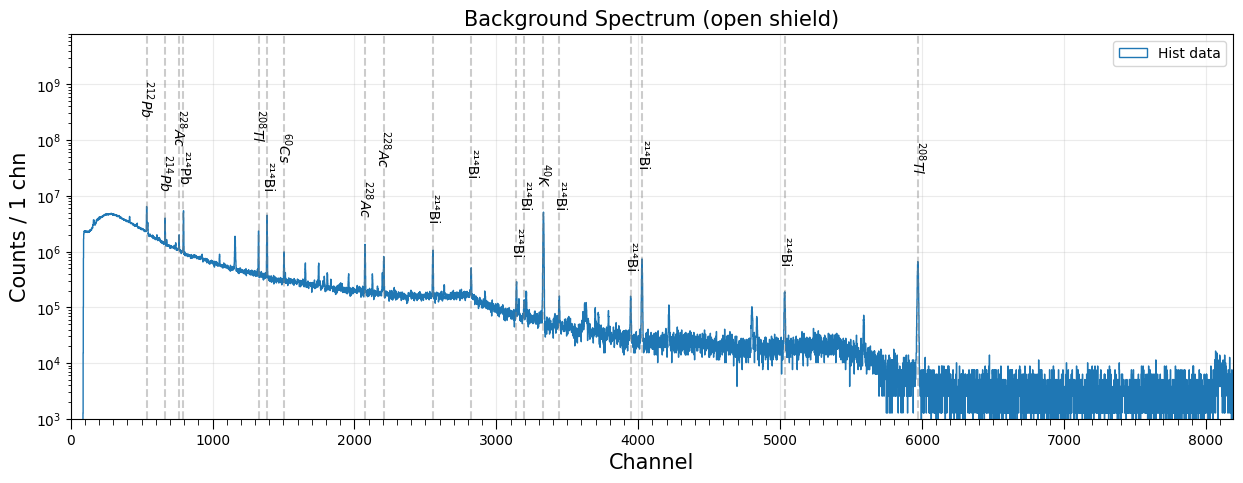

In [42]:
plt.figure(figsize=(15, 5))


dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




chn = np.arange(len(spectrum_open))  # canali da 0 a N-1
#plt.bar(chn, spectrum_bkg, width=1.0, label='Spectrum')
#plt.plot(spectrum_bkg, lw = 0.5, label='Spectrum')

isotopes= ['$^{212}Pb$','$^{214}Pb$',
           '$^{228}Ac $',  '²¹⁴Pb', 
               '$^{208}Tl $','²¹⁴Bi',
           '$^{60}Cs $','$^{228}Ac $','$^{228}Ac $',
               '²¹⁴Bi','²¹⁴Bi',
               '²¹⁴Bi','²¹⁴Bi',
                '$^{40}K $',
                '²¹⁴Bi','²¹⁴Bi',
              '²¹⁴Bi', '²¹⁴Bi','$^{208}Tl $']



bins = np.linspace(min(chn), max(chn), len(chn)+1)
counts, bin_edges, _ = plt.hist(chn, bins=bins, weights=spectrum_open,
                                      histtype='step', label='Hist data')

db = bin_edges[1]-bin_edges[0]
plt.xlabel('Channel', size = 15)
plt.ylabel(f'Counts / {db:.0f} chn', size = 15)
plt.title('Background Spectrum (open shield)', size = 15)
plt.xlim(0, len(spectrum_open))
plt.ylim(1e3,max(spectrum_open)+ 8e9)
E_chn = np.sort(E_chn_plot)
for i, (chn, iso) in enumerate(zip(E_chn, isotopes)):
    if chn < len(spectrum_open):
        # Alterna l'altezza del testo tra 1x e 3x
        factor = 40 if i % 2 == 0 else 3
        plt.text(chn, spectrum_open[chn]*factor, f"{iso}",
                 rotation=270, va='bottom', ha='center', size=10, color='black')
        plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)

plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.savefig("new image/spettro_chn_op", dpi=300, bbox_inches='tight')

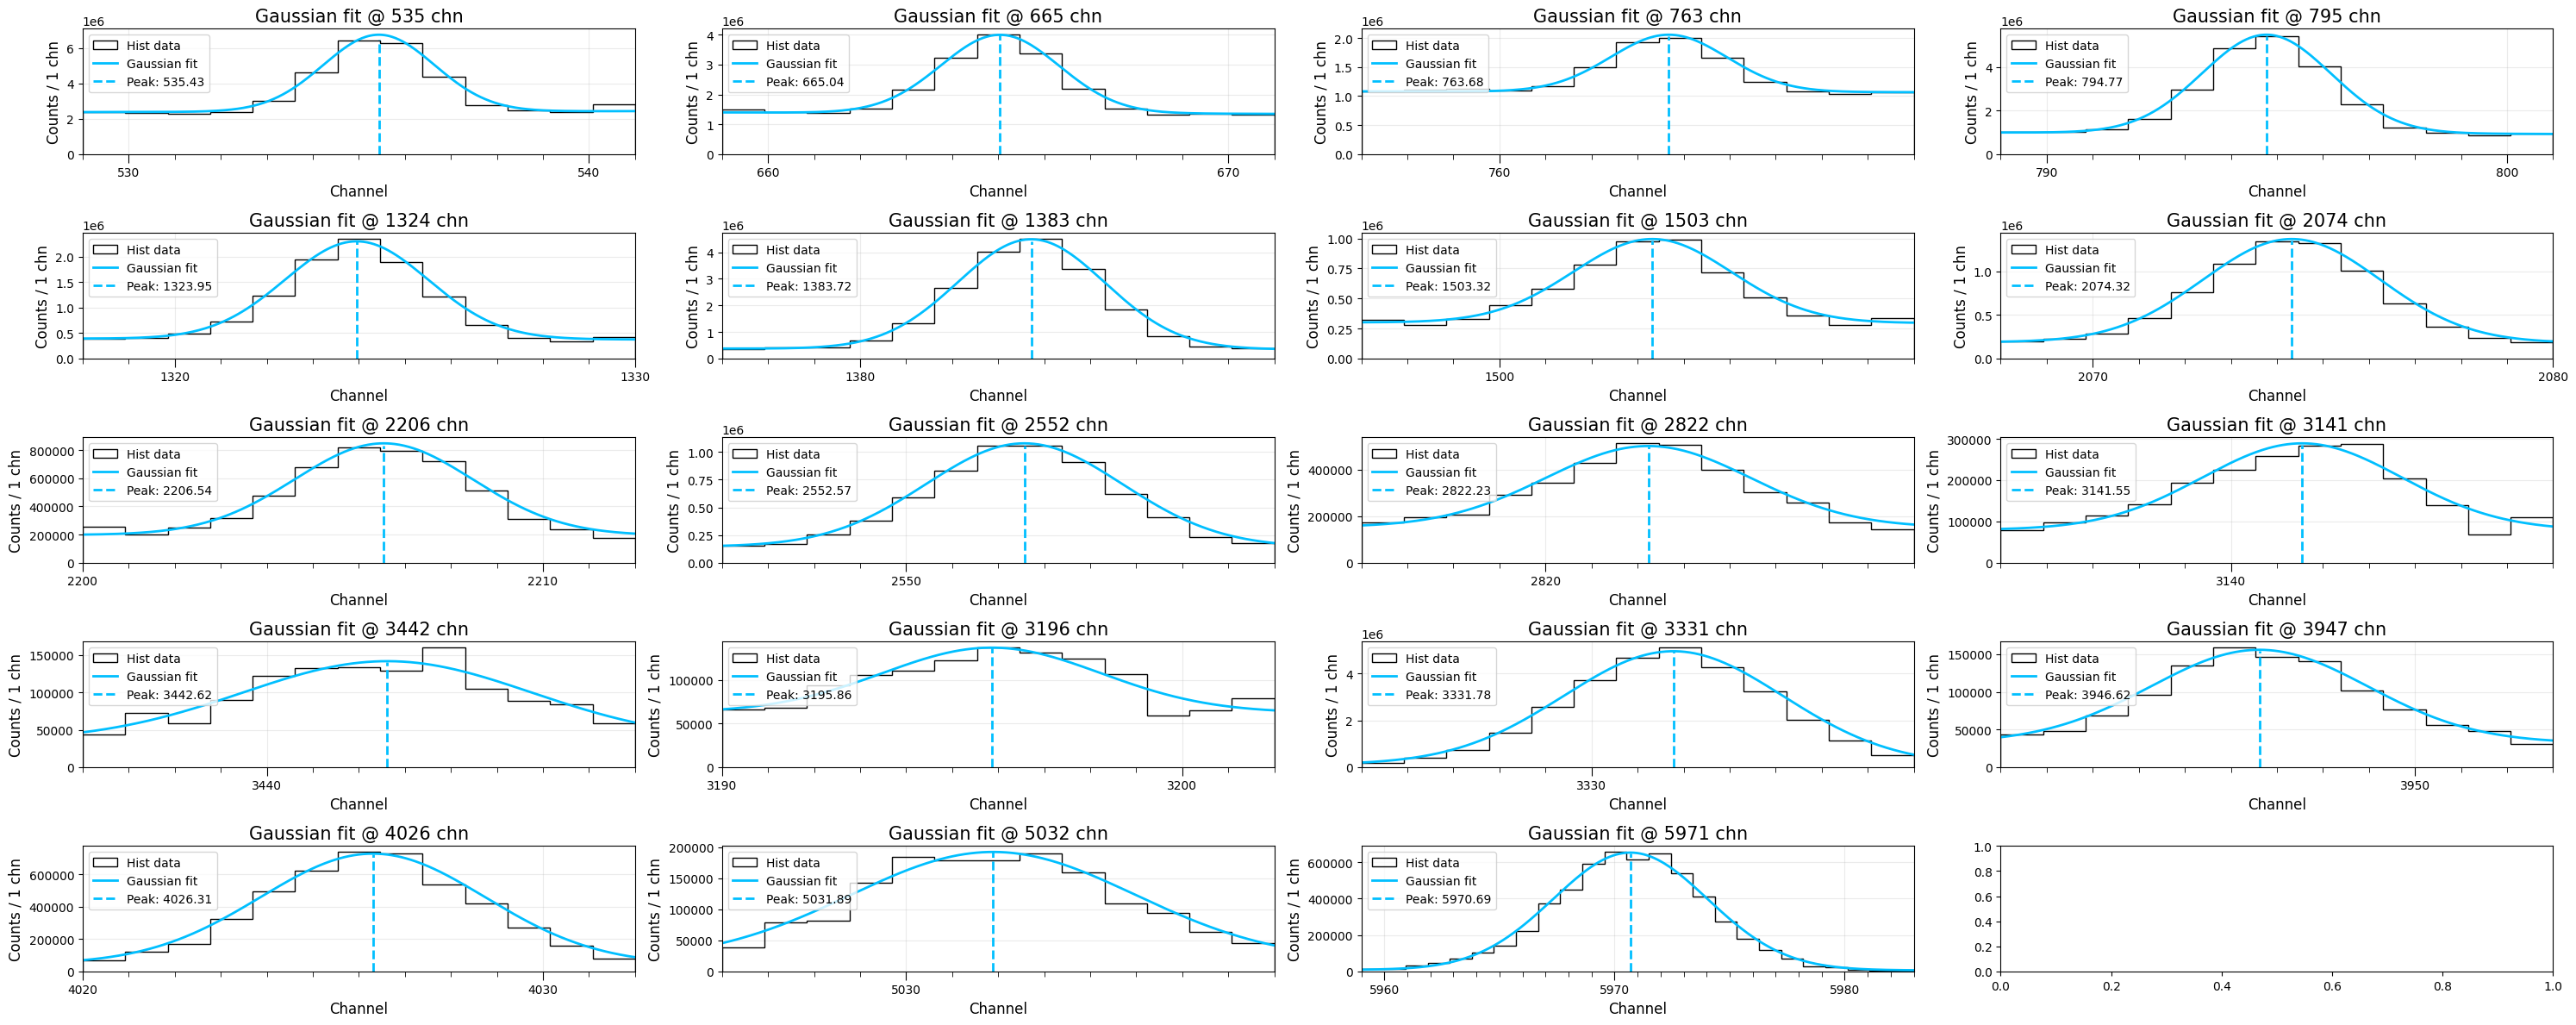

In [327]:
fig, axes = plt.subplots(5, 4, figsize=(30, 12))  # 1 riga, 3 colonne

#E_chn = [1158, 3331, 5970] 
popt_chn = []
popt_chn_err = []
axes = axes.flatten() 
for i, e in enumerate(E_chn_plot):
   # print(i+1)
    ax = axes[i]
    if e == E_chn[-1]:
        dx =12
    else:
        dx = 6
    popt, err, _ = fit_func(spectrum_open, e, dx=dx, ax=ax)
    popt_chn.append(popt)
    popt_chn_err.append(err)

popt_chn = np.vstack(popt_chn)

popt_chn_err = np.vstack(popt_chn_err)
plt.savefig("HPGE open background/chn_bkg_peaks", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [328]:
len(E_kev)

19

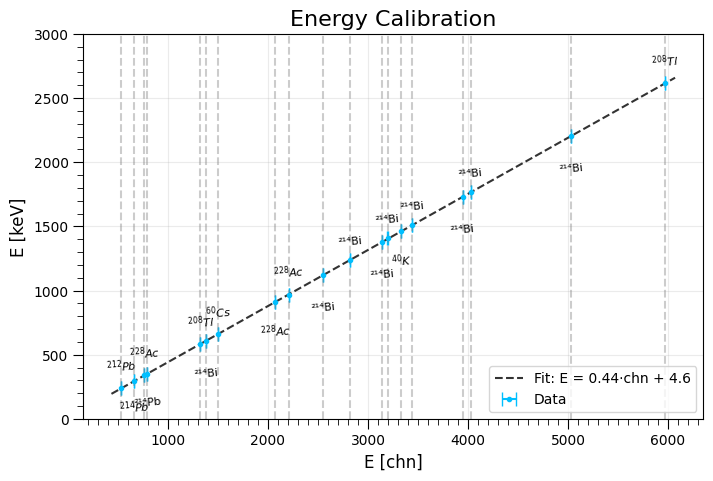

In [358]:
#E_kev = [511, 1460.830, 2614] #kev
E_kev_plot = [238.632, 338.32, 351.932, 295,  583, 609,  661.66,911.20, 969, 1120, 1238, 1377, 1407, 1460.83, 1509, 1729, 1764,2204, 2614]
E_chn = np.sort(E_chn_plot)
E_kev = np.sort(E_kev_plot)
popt_chn_arr = np.sort( popt_chn[:,1])


plt.figure(figsize=(8, 5))



dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

dx = 500
dy = 100
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.yaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='y', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='y', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




plt.errorbar(popt_chn_arr,E_kev, xerr=popt_chn_err[:,1], fmt='o', color = 'deepskyblue', markersize = 3, capsize=5, label='Data')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, popt_chn_arr, E_kev, p0=p0 )
# Incertezze
perr = np.sqrt(np.diag(pcov))
a_open = popt[0]
b_open = popt[1]

for i, (chn, iso) in enumerate(zip(popt_chn_arr, isotopes)):
    if chn < len(spectrum_open):  # Controllo sicurezza
        if i< 5:
            dy = 275
        else:
            dy = 300
        y_pos = E_kev[i] + (100 if i % 2 == 0 else -dy)  # Alterna altezza per evitare sovrapposizione
        plt.text(chn, y_pos, iso,
                 rotation=5, va='bottom', ha='center', fontsize=8, color='black')
        plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)

# Plot
x_fit = np.linspace(min(popt_chn[:,1])-100, max(popt_chn[:,1])+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', markersize = 0.05, alpha = 0.8)

plt.ylim(0, 3000)
plt.legend(fontsize = 10)
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("HPGe images/ E_cal_bkg", dpi=300, bbox_inches='tight')

In [351]:
 print(a_open , '+/-', perr[0])
print(b_open , '+/-', perr[1])

0.43713112429815837 +/- 0.00021122681619888147
4.560506618046007 +/- 0.6268152873380175


In [352]:
channels_open = np.arange(len(spectrum_open))         # x originale
energies_open = a_open * channels_open + b_open

In [353]:
mask = (energies_open > 0) & (energies_open < 3000)
spectr_3Mev = energies_open[mask]

print(np.sum(spectr_3Mev))
print('attività grezza', np.sum(spectr_3Mev)/(t_real_open), 'cps')

10294382.923690615
attività grezza 176.29179237063082 cps


In [354]:
E_kev

array([ 238.632,  295.   ,  338.32 ,  351.932,  583.   ,  609.   ,
        661.66 ,  911.2  ,  969.   , 1120.   , 1238.   , 1377.   ,
       1407.   , 1460.83 , 1509.   , 1729.   , 1764.   , 2204.   ,
       2614.   ])

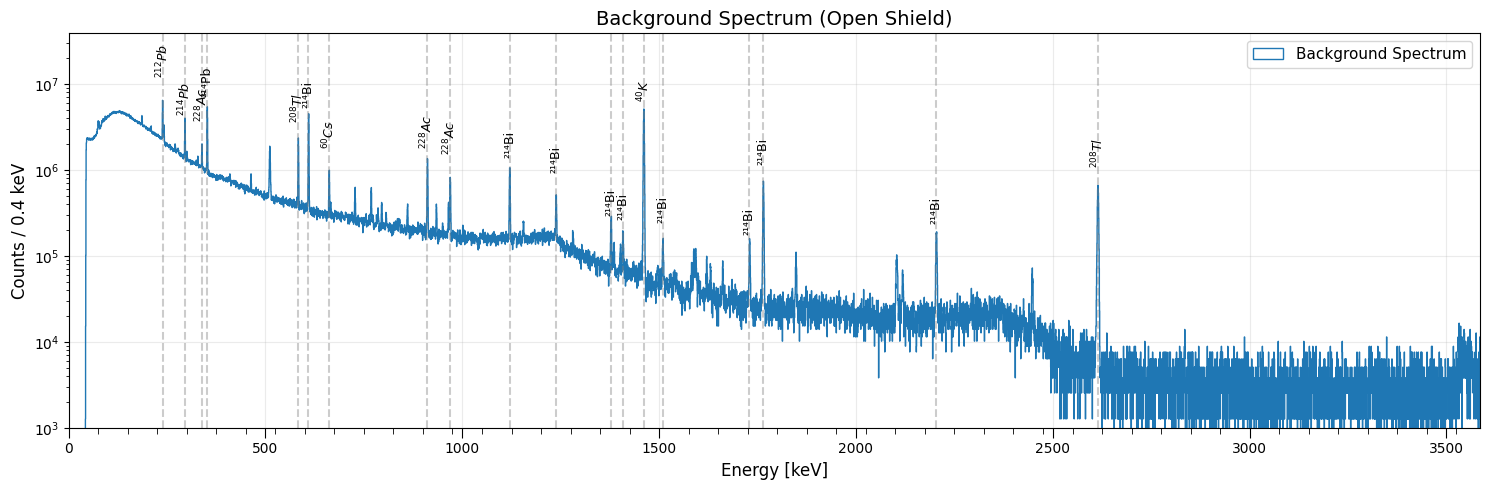

In [363]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

plt.figure(figsize=(15, 5))

# Configurazione assi x
dx = 500
dy = 75
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))
ax.xaxis.set_minor_locator(MultipleLocator(dy))
ax.tick_params(axis='x', which='major', length=7, labelsize=10)
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)

# Istogramma
bins = np.linspace(min(energies_open), max(energies_open), len(energies_open))
counts, bin_edges, _ = plt.hist(energies_open, bins=bins, weights=spectrum_open,
                                lw=0.5, histtype='step', label='Background Spectrum')
db = bin_edges[1] - bin_edges[0]

# Annotazioni isotopi
for i, (energy, iso) in enumerate(zip(E_kev, isotopes)):
    if min(energies_open) < energy < max(energies_open):
        # Trova il bin index più vicino per posizionare correttamente l'etichetta
        idx = np.abs(energies_open - energy).argmin()
        y_val = spectrum_open[idx]
        y_pos = y_val * (1.8 if i % 2 == 0 else 1.3)
        plt.text(energy, y_pos, iso,
                 rotation=90, va='bottom', ha='center', size=9, color='black')
        plt.axvline(x=energy, color='gray', linestyle='--', alpha=0.4)

# Etichette assi e titolo
plt.xlabel('Energy [keV]', fontsize=12)
plt.ylabel(f'Counts / {db:.1f} keV', fontsize=12)
plt.title('Background Spectrum (Open Shield)', fontsize=14)

# Limiti assi
plt.xlim(0, max(energies_open))
plt.ylim(1e3, np.max(spectrum_open)*6)  # log scale → evitare zero

# Scala logaritmica y
plt.yscale('log')

# Legenda, griglia e salvataggio
plt.legend(loc='upper right', fontsize=11)
plt.grid(alpha=0.25)

plt.tight_layout()
plt.savefig("HPGe images/spectrum_bkg_kev.png", dpi=300, bbox_inches='tight')


[5.96056602e+06 2.38618170e+02 5.41233515e-01 9.81438164e+03
 1.00000001e+00]
[1.93801416e+05 1.30447290e-02 1.52707003e-02 2.75788426e+04
 6.60537709e+06]
[ 3.71130399e+06  2.95272580e+02  5.64680221e-01 -8.90718016e+03
  3.99871957e+06]
[1.11385183e+05 1.05094104e-02 1.32980835e-02 1.58160421e+04
 4.64350295e+06]
[ 1.34389063e+06  3.38391477e+02  5.47966227e-01 -2.73549952e+03
  2.00570696e+06]
[7.00924137e+04 1.95718979e-02 2.35920726e-02 1.02378262e+04
 3.45338541e+06]
[ 6.93419800e+06  3.51983306e+02  6.12055549e-01 -1.00000000e+04
  4.48484613e+06]
[1.34052650e+05 9.00663597e-03 1.02965384e-02 1.46781804e+04
 5.17637664e+06]
[ 3.22024370e+06  5.83307551e+02  6.76576394e-01 -3.33649071e+03
  2.34591548e+06]
[1.46396308e+05 1.66563716e-02 2.14811583e-02 1.70044655e+04
 9.88233393e+06]
[ 7.19872881e+06  6.09429889e+02  6.96926469e-01 -6.77417118e+03
  4.49506857e+06]
[1.96522252e+05 1.15433383e-02 1.42465954e-02 2.02280074e+04
 1.22847469e+07]
[ 1.46132784e+06  6.61708494e+02  8.080

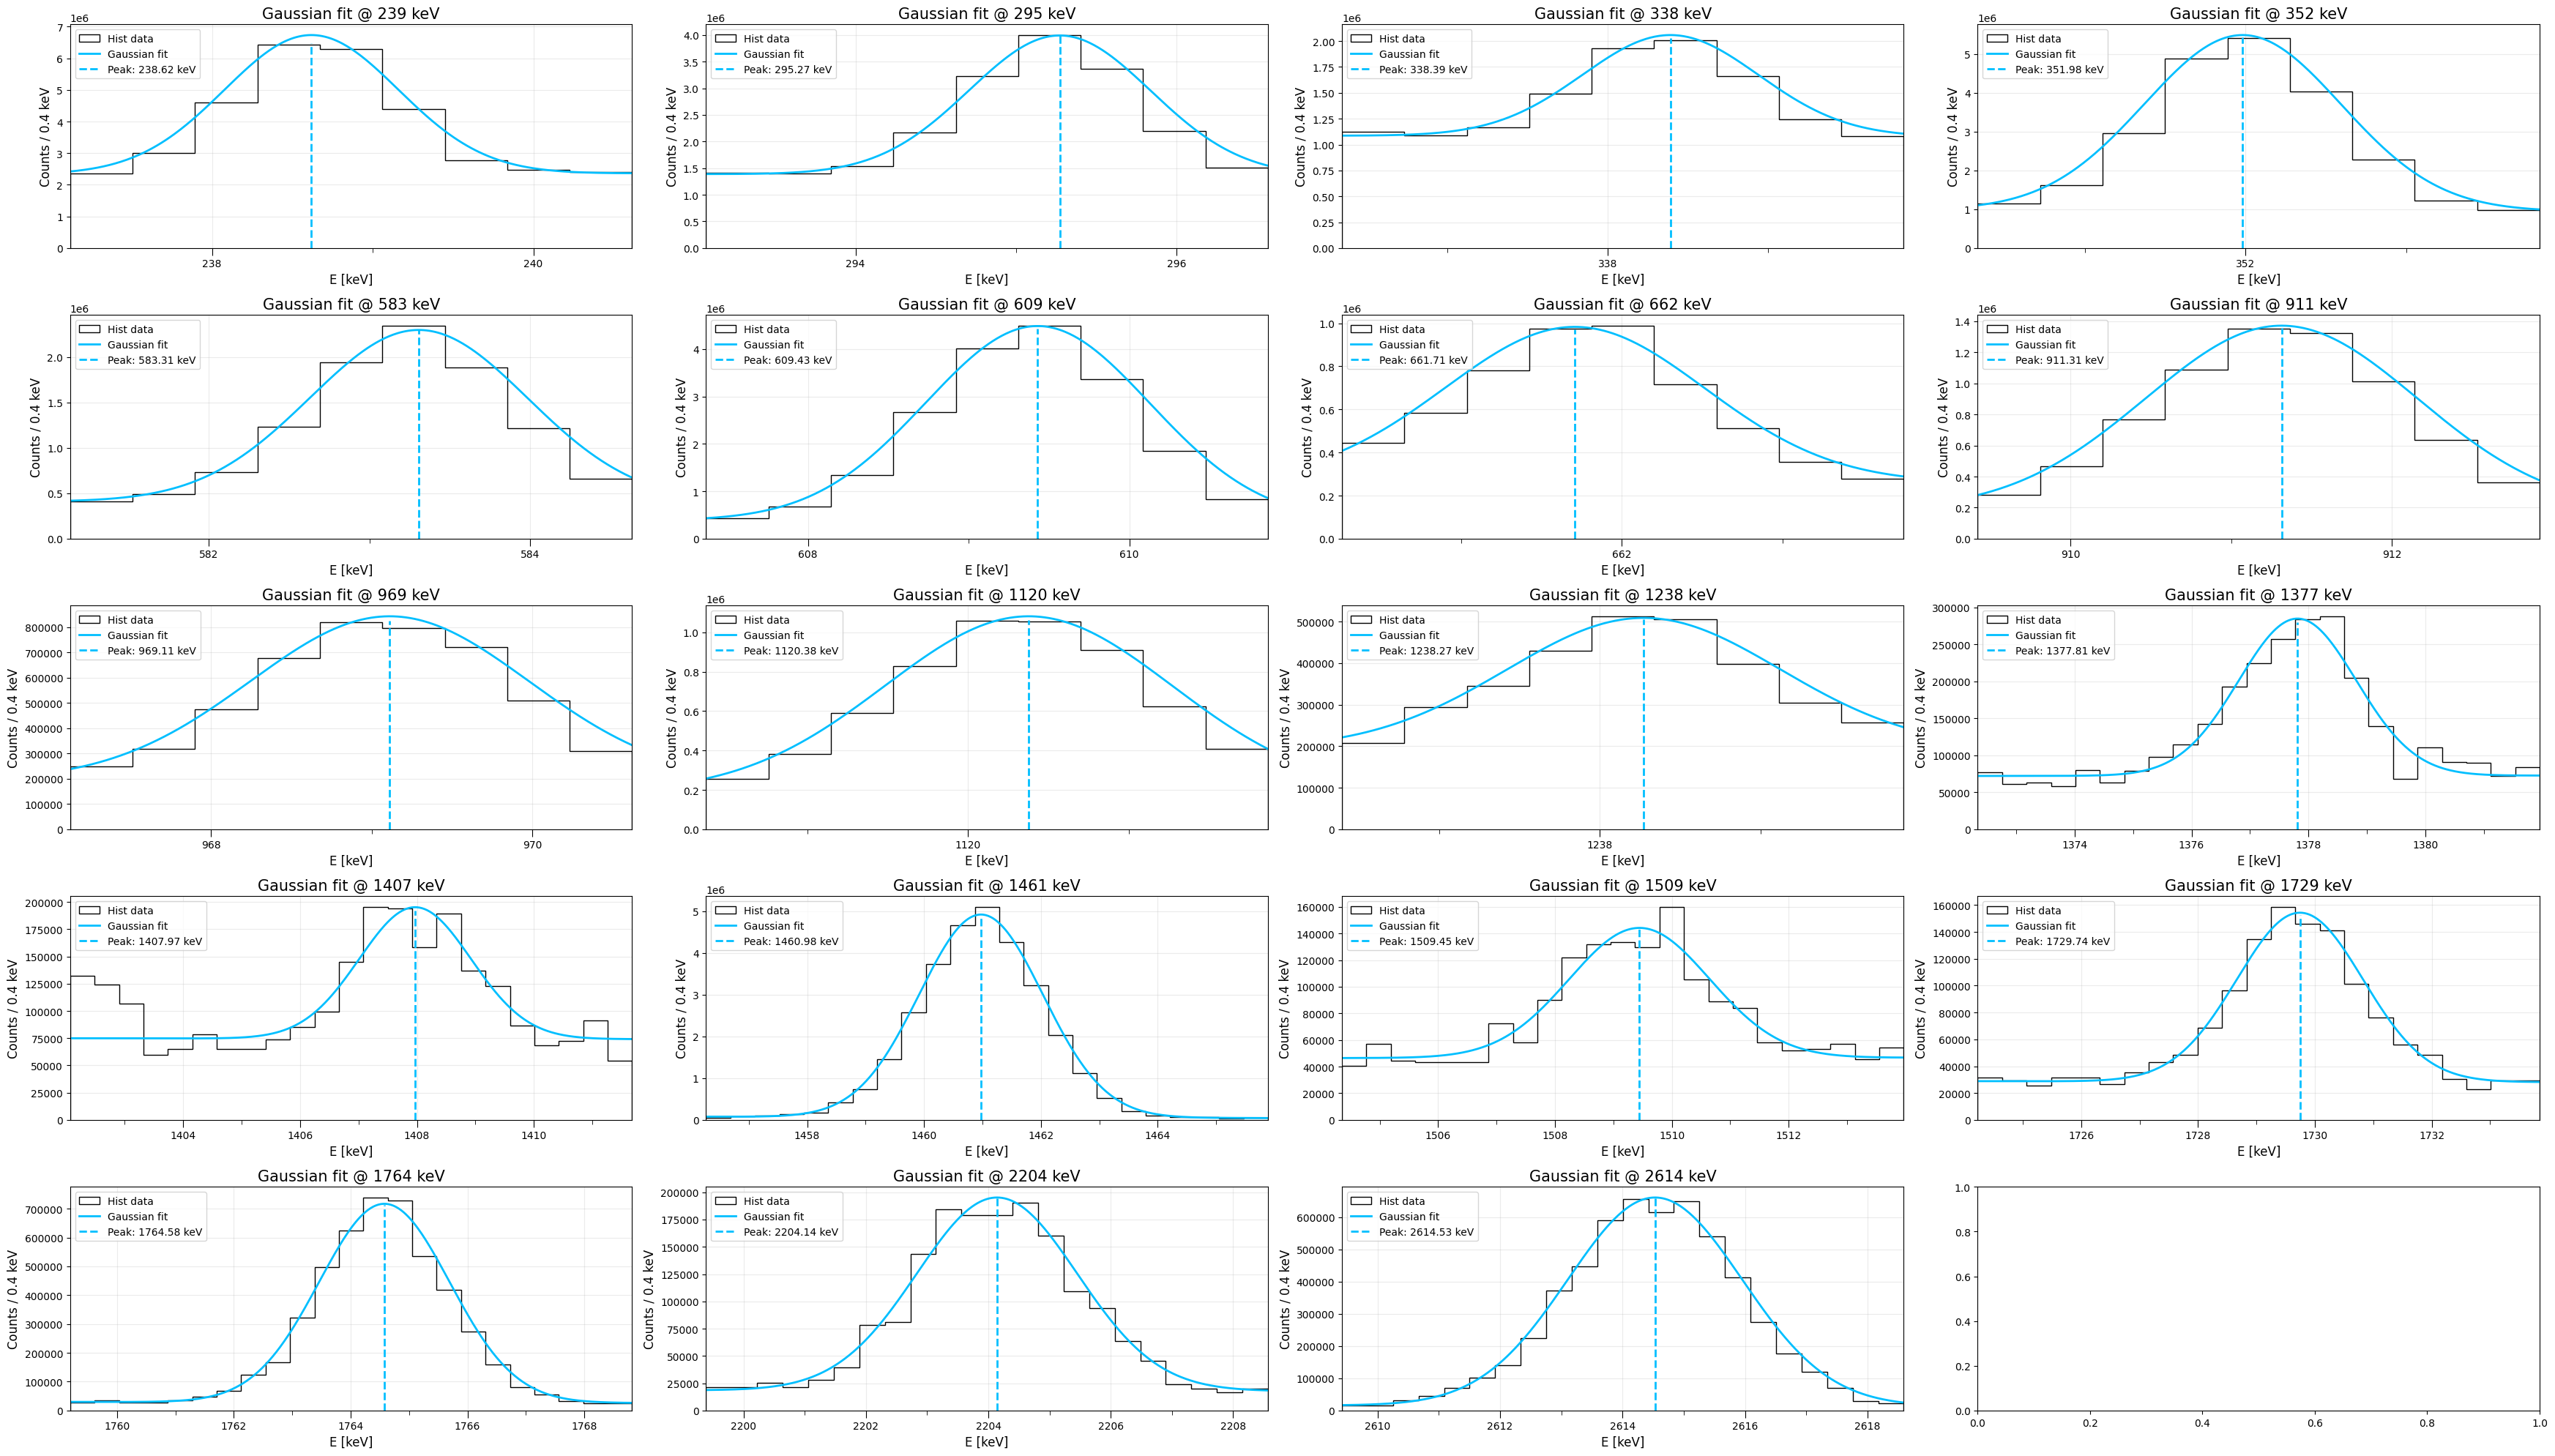

In [99]:
fig, axes = plt.subplots(5, 4, figsize=(35, 20))  # 1 riga, 3 colonne
#E_kev = np.sort([ 511, 1460.83, 2614 ]) #kev
popt_kev = []
popt_kev_err = []
dofs = []
axes = axes.flatten() 
for i, e in enumerate(E_kev):
    if i <=10:
        dx = 2
    else:
        dx = 5
    popt, err, dof = fit_func( spectrum_open, e, dx = dx, kev = True, energies = energies_open, ax=axes[i])
    print(popt)
    print(err)
    popt_kev.append(popt)
    popt_kev_err.append(err*2.5)
    dofs.append(dof)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)
#dofs = np.vstack(dofs)

plt.tight_layout()
plt.savefig("HPGE open background/energy_peak_fit_bkg", dpi=300, bbox_inches='tight')
plt.show()


In [100]:
for i in range(0, len(popt_kev[:,1])):
    mu_kev = popt_kev[:,1]
    mu_kev_err = popt_kev_err[:,1]
    mu_theo = E_kev[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo, dof = 1)
    

t = -0.42
✅ p > 0.05 
p-value = 0.7447
t = 10.37
✅ p > 0.05 
p-value = 0.0612
t = 1.46
✅ p > 0.05 
p-value = 0.3822
t = 2.28
✅ p > 0.05 
p-value = 0.2633
t = 7.39
✅ p > 0.05 
p-value = 0.0857
t = 14.90
❌ p < 0.05 
p-value = 0.0427
t = 0.31
✅ p > 0.05 
p-value = 0.8087
t = 2.30
✅ p > 0.05 
p-value = 0.2607
t = 0.83
✅ p > 0.05 
p-value = 0.5581
t = 6.76
✅ p > 0.05 
p-value = 0.0935
t = 1.38
✅ p > 0.05 
p-value = 0.3996
t = 4.12
✅ p > 0.05 
p-value = 0.1515
t = 2.47
✅ p > 0.05 
p-value = 0.2450
t = 4.86
✅ p > 0.05 
p-value = 0.1293
t = 1.87
✅ p > 0.05 
p-value = 0.3126
t = 7.98
✅ p > 0.05 
p-value = 0.0794
t = 11.69
✅ p > 0.05 
p-value = 0.0543
t = 1.15
✅ p > 0.05 
p-value = 0.4546
t = 7.07
✅ p > 0.05 
p-value = 0.0895


incertezza grandi solo 3 punti del fit
paramters: [6.68636917e-02 5.40426461e-17]
Errori: [2.76305126e-03 1.70826050e+01]


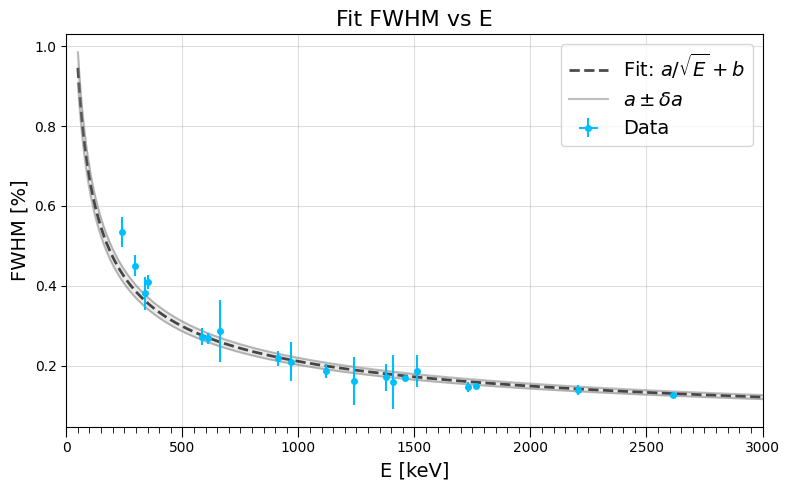

In [101]:
# Calcolo FWHM e incertezza
sigma= popt_kev[:,2]
sigma_err_kev=popt_kev_err[:,2]
mu_kev=popt_kev[:,1]
mu_kev_err =popt_kev_err[:,1]
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,100])
p0=[3,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma= FWHM_err, p0=p0, bounds=boundary)
perr_open_res = np.sqrt(np.diag(pcov))

a_open_res = popt[0]
b_open_res = popt[1]

print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))


dx = 500
dy = 50
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, a_open_res, b_open_res)*100, label=r'Fit: $a/\sqrt{E} + b$',  color='black', ls = '--', alpha = 0.7, lw=2)

upper_curve = fhwm_func(E_fit, a_open_res + perr_open_res[0], b_open_res) * 100
lower_curve = fhwm_func(E_fit, a_open_res - perr_open_res[0], b_open_res) * 100

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.5, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.5)

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*100,
             fmt='o',  
             color = 'deepskyblue', 
             markersize=4,               # dimensione punto
             label='Data')

# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.xlim(0, 3000)
plt.title('Fit FWHM vs E',  size = 16)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig("HPGE open background/FWHM open baclground", dpi=300, bbox_inches='tight')
plt.show()

# Uranium Spectrum

In [315]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625
# correggo subito per il tempo morto
D_u = 1-(t_live_u/t_real_u)

spectrum_U = spectrum_U/D_u

In [316]:
E_chn_U = [ 415, 543,665,794, 1382, 1746,2125, 2550,4024]
E_kev_U = [ 185.712, 242,295.224, 351.932,  609.312,768.356, 934.061, 1120,  1764.494]
E_kev_U = [ 186.221, 242,295.224, 351.932,  609.312,768.356, 934.061, 1120,  1764.494]

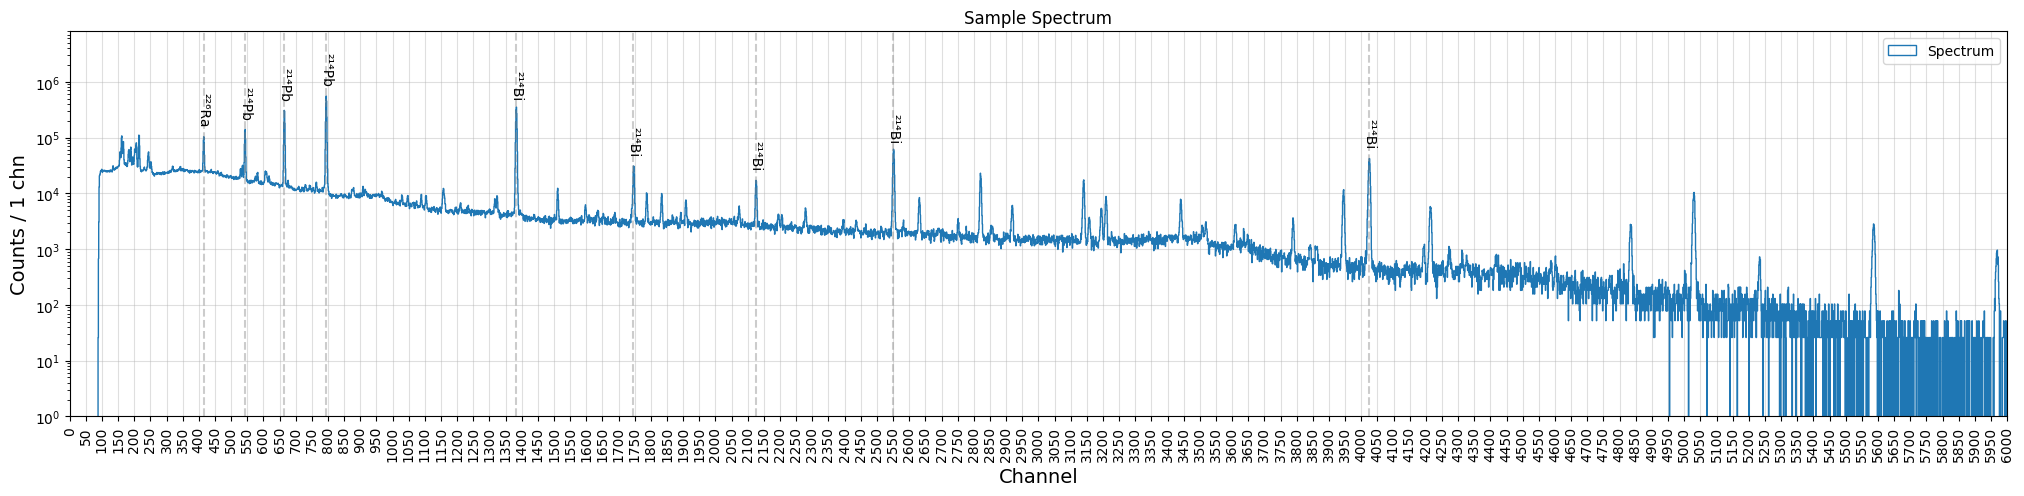

In [317]:
# Canali dei picchi identificati nello spettro
#E_chn_U = [415, 543, 665, 794, 1382, 1746, 2125, 4024]
# Isotopi corrispondenti
isotopes = ['²²⁶Ra', '²¹⁴Pb', '²¹⁴Pb', '²¹⁴Pb', '²¹⁴Bi', '²¹⁴Bi','²¹⁴Bi','²¹⁴Bi',  '²¹⁴Bi']

plt.figure(figsize=(25, 5))
#plt.plot(spectrum_U, lw=0.5, label='Spectrum')

chn =  np.arange(len(spectrum_U))
bins =  np.linspace(min(chn), max(chn), len(chn), +1 )
counts, bin_edge, _ = plt.hist(chn, bins = bins, weights = spectrum_U,  histtype='step', label = 'Spectrum' )
db = bin_edge[1]-bin_edge[0]
# Etichette degli isotopi sui picchi
for chn, iso in zip(E_chn_U, isotopes):
    plt.text(chn, spectrum_U[chn]*1.5, f"{iso}",
             rotation=270, va='bottom', ha='center', size=10, color='black')
    plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)
chn =  np.arange(len(spectrum_U))
plt.xticks(np.arange(min(chn), max(chn), 50), rotation=90)
plt.xlabel('Channel', size=14)
plt.ylabel(f'Counts / {db:.0f} chn', size=14)
plt.title('Sample Spectrum')
#plt.title('Uranium Spectrum', size=15)
#plt.xlim(0, 6000)
plt.xlim(0, 6000)
plt.ylim(1, 8e6)
plt.yscale('log')
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("HPGe images/238U/ 238U_channel", dpi=300, bbox_inches='tight')
plt.show()

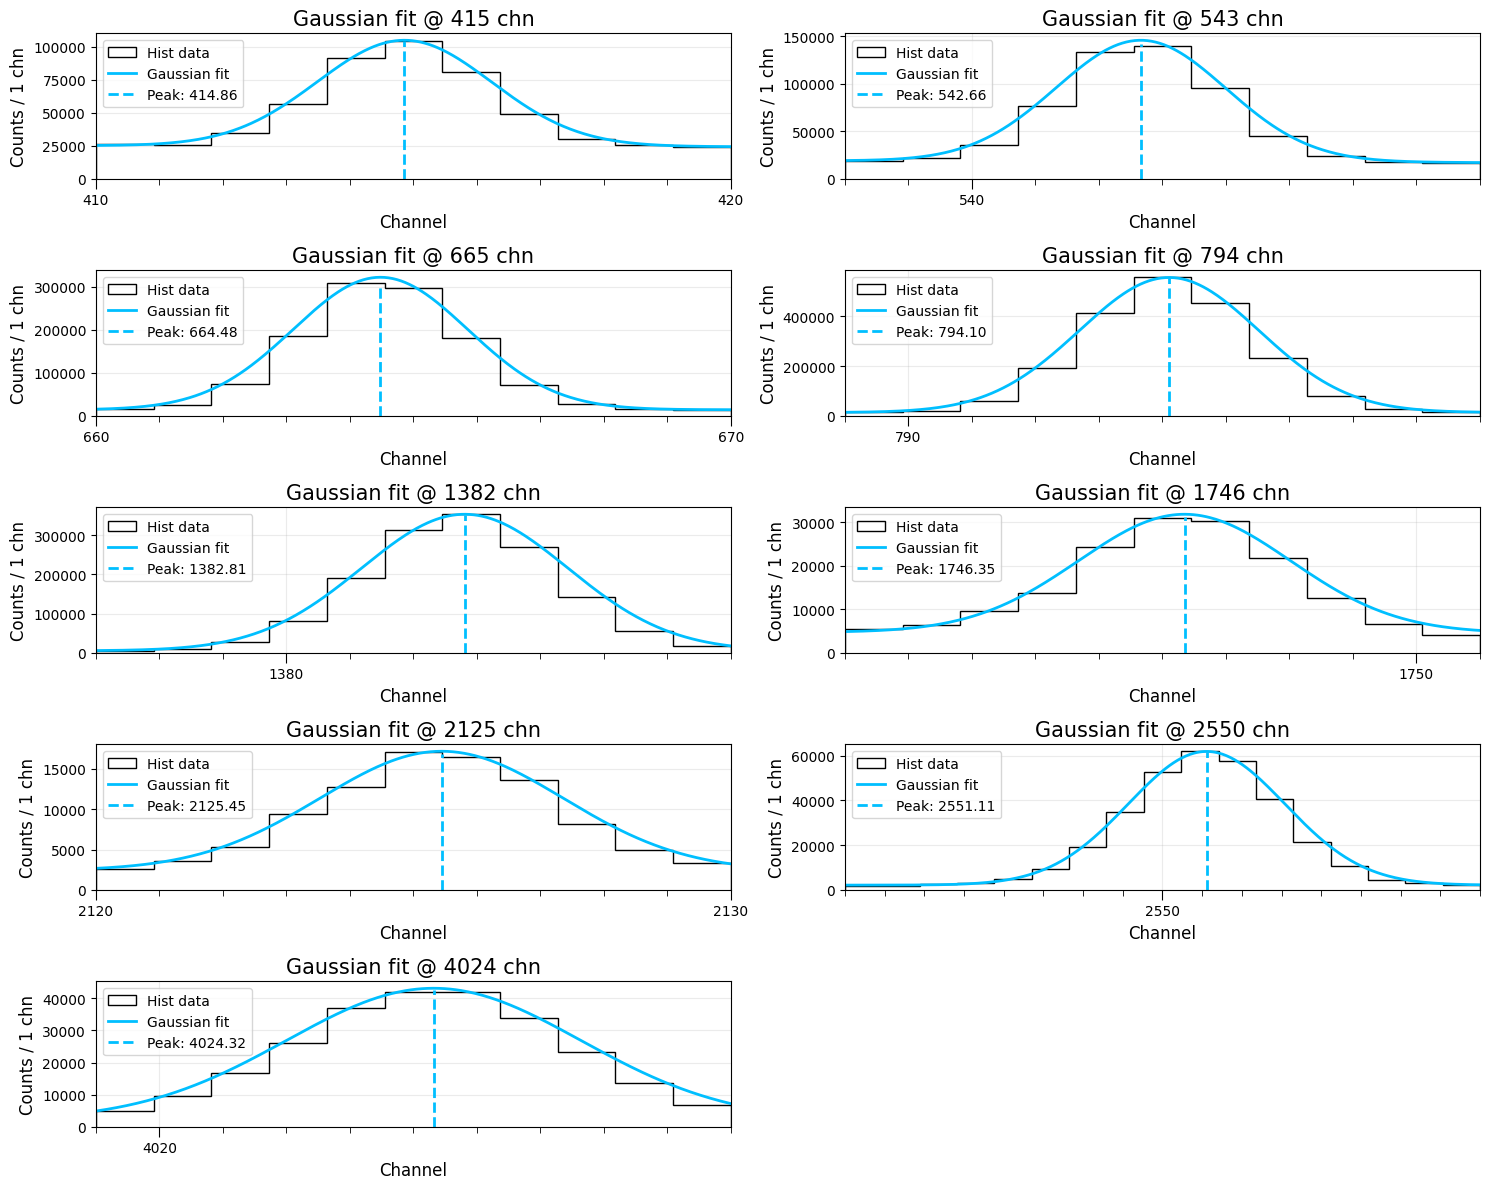

In [107]:
fig, axes = plt.subplots(5, 2, figsize=(15, 12))  # 10 subplot totali

popts_U = []
err_U = []

axes = axes.flatten()  # Rende la matrice 2D in un array 1D per iterare più facilmente

for i, e in enumerate(E_chn_U):
    ax = axes[i]
    dx = 8 if i == 7 else 5
    popt, err, _ = fit_func(spectrum_U, e, dx=dx, ax=ax)
    popts_U.append(popt)
    err_U.append(err)

# Rimuove i subplot vuoti
for j in range(len(E_chn_U), len(axes)):
    fig.delaxes(axes[j])

popts_U = np.vstack(popts_U)
err_U = np.vstack(err_U)

plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()


In [108]:
E_kev_U

[186.221, 242, 295.224, 351.932, 609.312, 768.356, 934.061, 1120, 1764.494]

Uncertainty on a: 0.000211, on b: 0.63


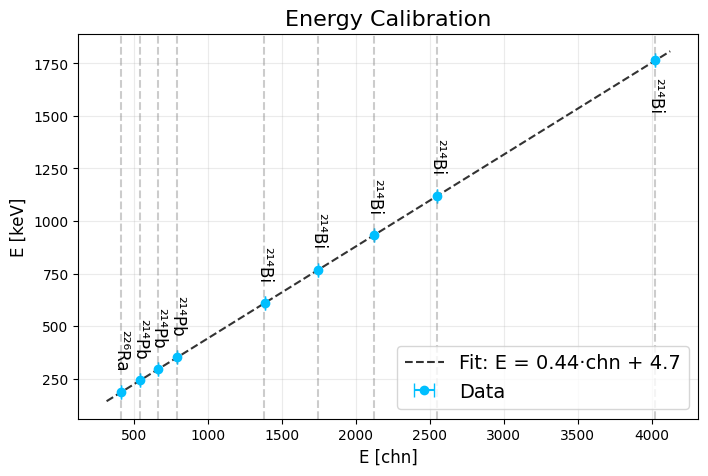

In [109]:
mu_chn = popts_U[:, 1]
mu_chn_err = err_U[:, 1]
plt.figure(figsize=(8, 5))
plt.errorbar( mu_chn,E_kev_U, xerr=mu_chn_err, fmt='o', color = 'deepskyblue', capsize=5, label='Data')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, mu_chn, E_kev_U, p0=p0 )
# Incertezze
perr_U = np.sqrt(np.diag(pcov))
print(f"Uncertainty on a: {perr[0]:.6f}, on b: {perr[1]:.2f}")
a = popt[0]
b = popt[1]

# Plot
x_fit = np.linspace(min(mu_chn)-100, max(mu_chn)+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)
for idx, (chn, iso) in enumerate(zip(E_chn_U, isotopes)):
    if idx == 8:
        plt.text(chn, E_chn_U[idx]*a + b - 250 , f"{iso}",
                 rotation=270, va='bottom', ha='center', size=12, color='black')
    else:
        plt.text(chn, E_chn_U[idx]*a + b + 100 , f"{iso}",
                 rotation=270, va='bottom', ha='center', size=12, color='black')
    plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)
plt.legend(fontsize = 14)
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("HPGe images/238U/E_ene_cal", dpi=300, bbox_inches='tight')

In [110]:
print('b', b)
print('b bkg', b_bkg)
print('a', a)
print('a bkg', a_bkg)

b 4.707398111833535
b bkg 4.682979221543532
a 0.43725765668608796
a bkg 0.4373829474144022


In [111]:
channels = np.arange(len(spectrum_U))         # x originale
energies = a * channels + b

In [112]:
for i in range(0,len(energies)):
    if spectrum_U[i] != 0:
        print(f' Energy threshold at {energies[i] + 15 : .2f} keV' )
        break

 Energy threshold at  58.19 keV


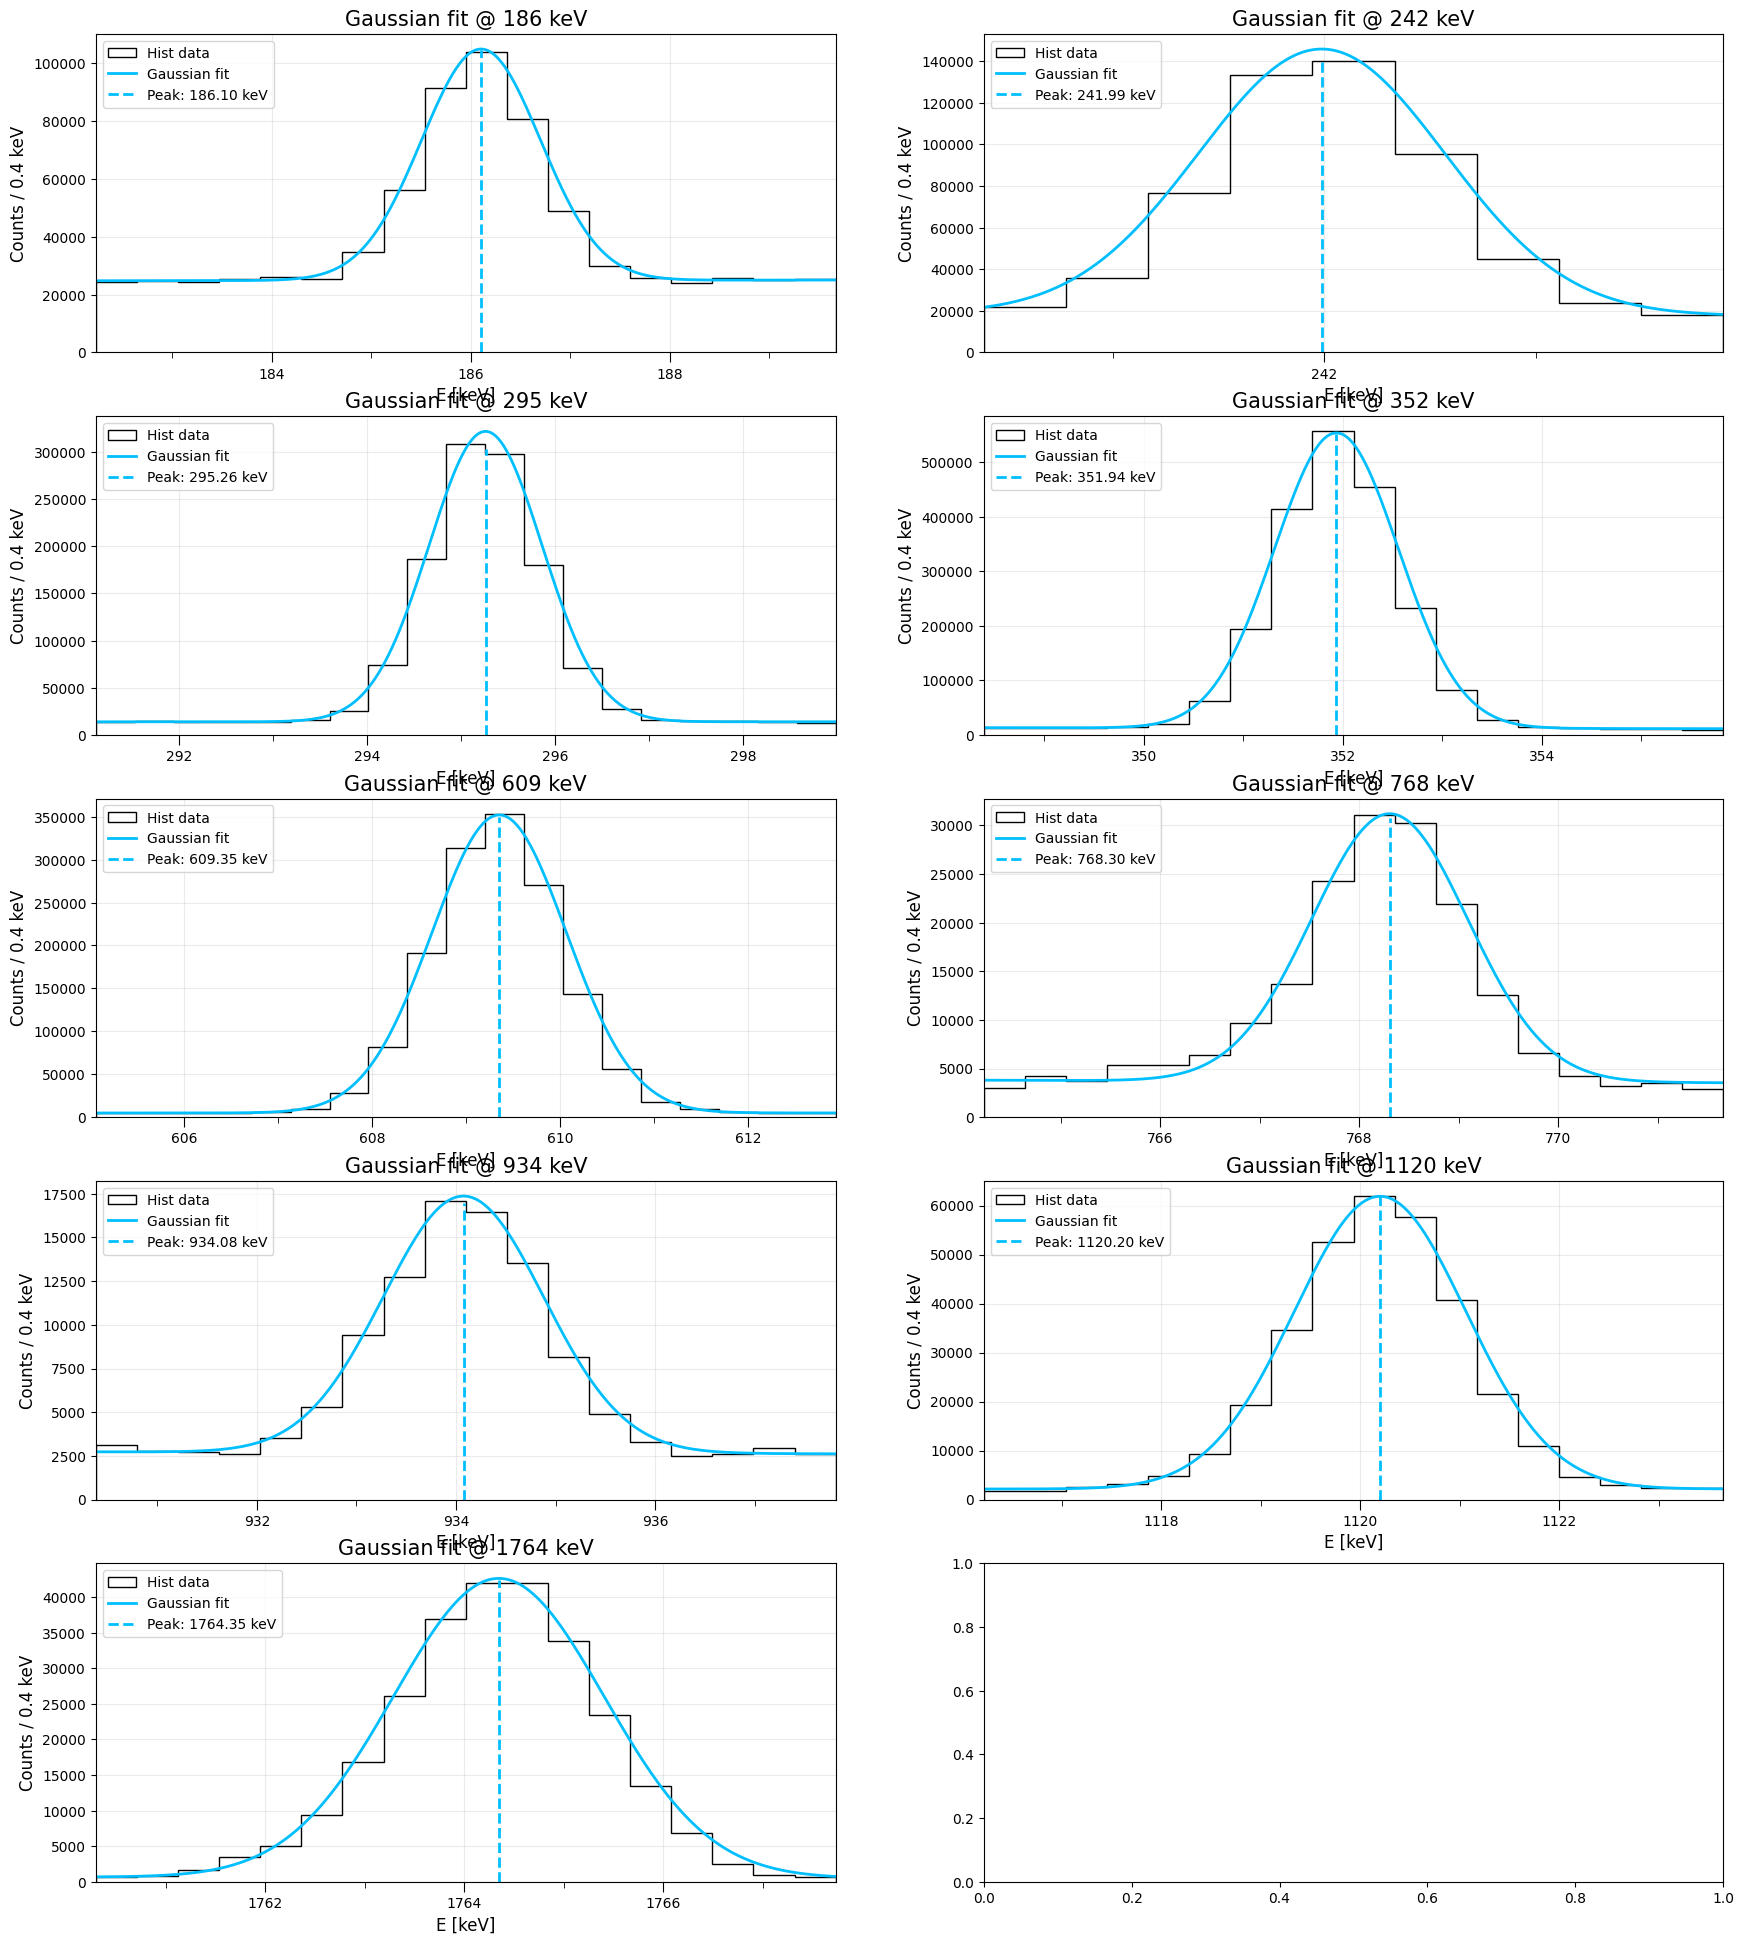

In [113]:
popts_U_kev = []
err_U_kev = []
dofs = []
fig, axes = plt.subplots(5,2, figsize=(21, 24))  # 1 riga, 3 colonne
for i, e in enumerate(E_kev_U):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    if e == E_kev_U[1]:
        dx = 2
    else:
        dx = 4
    popt, err, dof = fit_func(spectrum_U, e, dx =dx, kev = True, energies = energies, ax = ax)
    popts_U_kev.append(popt)
    err_U_kev.append(err*5)
    dofs.append(dof)
popts_U_kev = np.vstack(popts_U_kev)
err_U_kev = np.vstack(err_U_kev)

plt.savefig("HPGe images/ energy_peak_fit_U", dpi=300, bbox_inches='tight')

In [114]:
dofs

[13, 4, 14, 13, 14, 13, 13, 13, 13]

In [115]:
mu_kev=popts_U_kev[:,1]
mu_kev_err= err_U_kev[:,1]
for i in range(0, len(mu_kev)):
    mu_theo = E_kev_U[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo, dof = 1)
    

t = -3.34
✅ p > 0.05 
p-value = 0.1853
t = -0.35
✅ p > 0.05 
p-value = 0.7843
t = 1.71
✅ p > 0.05 
p-value = 0.3365
t = 0.22
✅ p > 0.05 
p-value = 0.8641
t = 1.27
✅ p > 0.05 
p-value = 0.4243
t = -0.29
✅ p > 0.05 
p-value = 0.8176
t = 0.15
✅ p > 0.05 
p-value = 0.9057
t = 3.24
✅ p > 0.05 
p-value = 0.1907
t = -1.26
✅ p > 0.05 
p-value = 0.4259


incertezza grandi solo 3 punti del fit
paramters: [7.57968435e-02 1.83019386e-16]
Errori: [6.79330420e-03 1.07967447e+02]


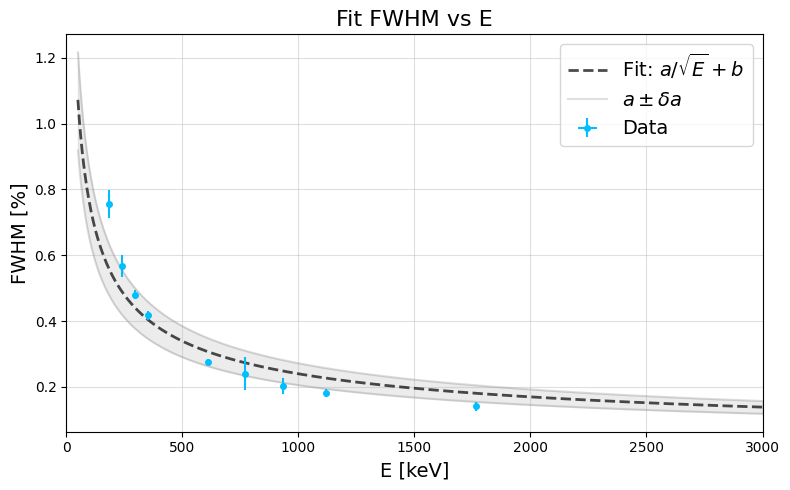

In [116]:
sigma=popts_U_kev[:,2]
sigma_err_kev = err_U_kev[:,2]
mu_kev=popts_U_kev[:,1]
mu_kev_err= err_U_kev[:,1]
# Calcolo FWHM e incertezza
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
FWHM_err = FWHM_err
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,1])
p0=[0.1,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err, p0=p0, bounds=boundary)
perr_U_res = np.sqrt(np.diag(pcov))
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit,*popt )*100, label=r'Fit: $a/\sqrt{E} + b$ ', color='black', ls = '--', alpha = 0.7, lw=2)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*100,
             fmt='o',     
             color = 'deepskyblue', 
             markersize=4,               # dimensione punto
             label='Data')
upper_curve = fhwm_func(E_fit, popt[0] + 1.5*perr_U_res[0], popt[1]) * 100
lower_curve = fhwm_func(E_fit, popt[0] - 1.6*perr_U_res[0], popt[1]) * 100

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.25, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.25)
a_res_U = popt[0]
b_res_U  = popt[1]
# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.title('Fit FWHM vs E',  size = 16)
plt.xlim(0,3000)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("HPGe images/238U/ FWHM_U", dpi=300, bbox_inches='tight')
plt.show()

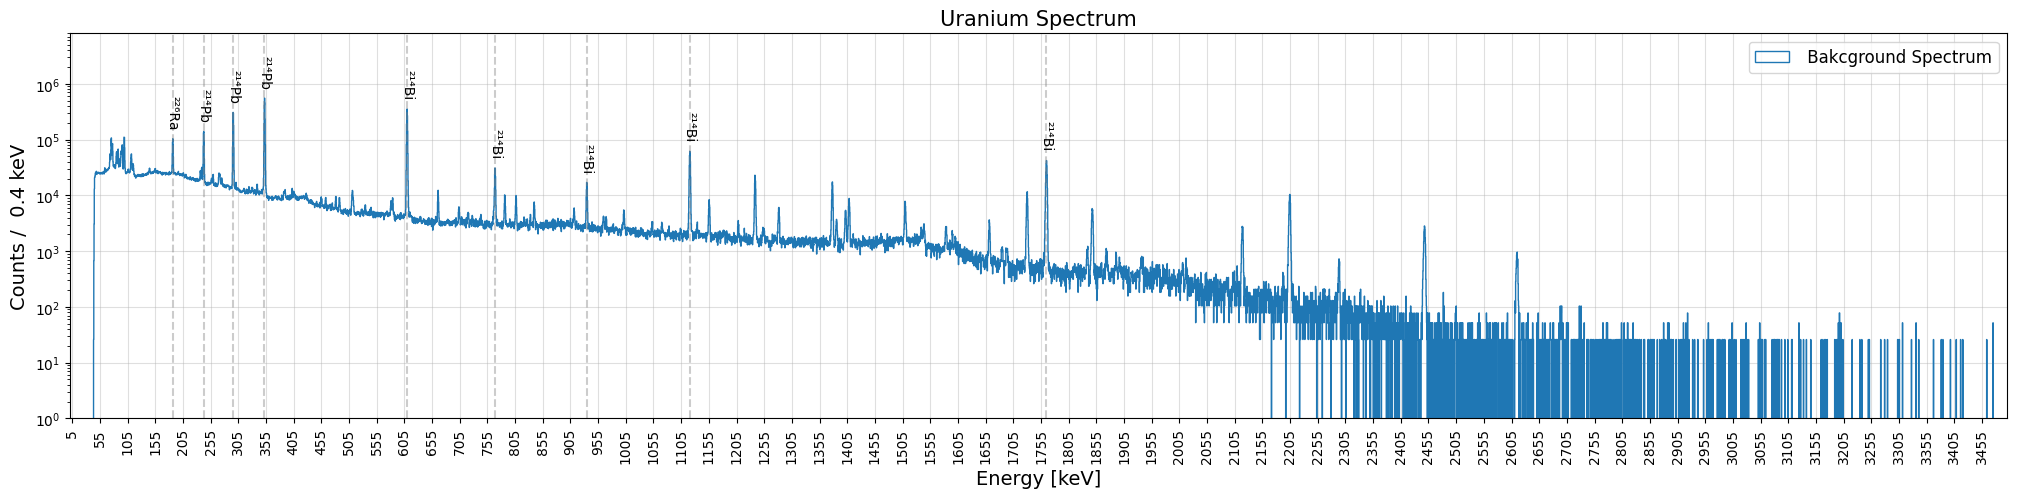

In [117]:
plt.figure(figsize=(25, 5))
bins = np.linspace(min(energies), max(energies), len(energies))
counts, bin_edge, _ = plt.hist(energies, bins = bins, weights = spectrum_U, lw = 0.25,  histtype='step',label=' Bakcground Spectrum')
db = bin_edge[1]-bin_edge[0]
# Colori per ogni fit
colors = plt.cm.cool(np.linspace(0, 1, len(popts_U_kev)))

# Fit gaussiani

for E, iso in zip(mu_kev, isotopes):
    y = np.interp(E, energies, spectrum_U)
    plt.text(E, y*1.5, f"{iso}",
             rotation=270, va='bottom', ha='center', size=10, color='black')
    plt.axvline(x=E, color='gray', linestyle='--', alpha=0.4)
    
plt.title('Sample Spectrum')
plt.xlabel('Energy [keV]', size=14)
plt.ylabel(f'Counts / {db : .1f} keV', size=14)
plt.title('Uranium Spectrum', size=15)
plt.xticks(np.arange(min(energies), max(energies), 50), rotation=90)
plt.xlim(0, 8000)
plt.ylim(1, 8e6)
plt.yscale('log')
plt.grid(alpha=0.4)
plt.xlim(0, 3500)
#plt.ylim(0, max(spectrum))
plt.yscale('log')
plt.legend(fontsize = 12)
plt.savefig("HPGe images/238U/U_energy_spectrum", dpi=300, bbox_inches='tight')
plt.show()

# Analis prova

In [364]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625


In [510]:
E_chn_U = [ 415, 543,665,794, 1382, 1746,2125, 2551,4024,
            1510, 1787.4, 1832.14, 2630, 2820.2, 2918.41, 3140,
            3440.86, 3944]
E_chn_U = np.sort(E_chn_U)
E_kev_U = [ 185.712, 242,295.224, 351.932,  609.312,768.356, 934.061, 1120.287,  1764.494,
             665.45, 785.356, 806.174, 1155.190, 1238.11, 1280.960, 1377.669,  1509.228, 1729.595 ]
E_kev_U = np.sort(E_kev_U)

In [426]:
E_chn_U

array([ 415.  ,  543.  ,  665.  ,  794.  , 1382.  , 1510.  , 1746.  ,
       1787.4 , 1832.14, 2125.  , 2551.  , 2630.  , 2820.2 , 2918.41,
       3140.  , 3440.86, 3944.  , 4024.  ])

In [511]:
E_chn_th = [528.9, 534.8, 
            763.0685714285713,
            1907.9600000000003,
            2072.517714285714,
            2194.5565714285717]
E_kev_th = [238.632,240.986, 338.32, 837.71, 911.204, 968.971]

In [512]:
E_chn_tot = np.concatenate((E_chn_U, E_chn_th))
E_kev_tot = np.concatenate((E_kev_U, E_kev_th))

In [513]:
len(E_chn_tot)

24

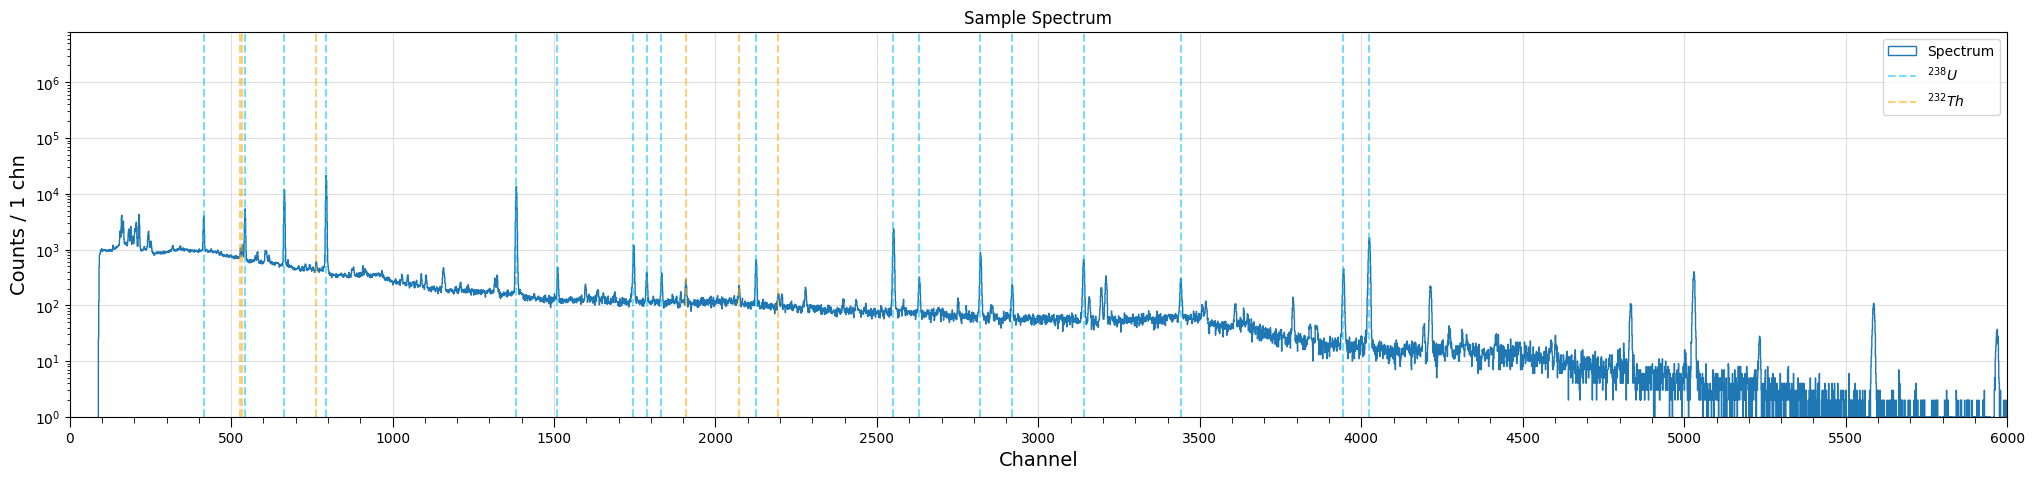

In [514]:
plt.figure(figsize=(25, 5))
#plt.plot(spectrum_U, lw=0.5, label='Spectrum')




dx = 500
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero



chn =  np.arange(len(spectrum_U))
bins =  np.linspace(min(chn), max(chn), len(chn), +1 )
counts, bin_edge, _ = plt.hist(chn, bins = bins, weights = spectrum_U,  histtype='step', label = 'Spectrum' )
db = bin_edge[1]-bin_edge[0]
# Etichette degli isotopi sui picchi
for i,chn in enumerate(E_chn_U):
    if  i == 0:
        plt.axvline(x=chn, color='deepskyblue', linestyle='--', alpha=0.54, label = r'$^{238}U$')
    else:
        plt.axvline(x=chn, color='deepskyblue', linestyle='--', alpha=0.54)
for i,chn in enumerate(E_chn_th):
    if i == 0:
        plt.axvline(x=chn, color='orange', linestyle='--', alpha=0.54,  label = r'$^{232}Th$')
    else:
        plt.axvline(x=chn, color='orange', linestyle='--', alpha=0.54)
chn =  np.arange(len(spectrum_U))
plt.xlabel('Channel', size=14)
plt.ylabel(f'Counts / {db:.0f} chn', size=14)
plt.title('Sample Spectrum')
#plt.title('Uranium Spectrum', size=15)
plt.xlim(0, 6000)

plt.ylim(1, 8e6)
plt.yscale('log')
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("HPGe images/238U/ 238U_channel", dpi=300, bbox_inches='tight')
plt.show()

In [515]:
len(E_chn_tot )

24

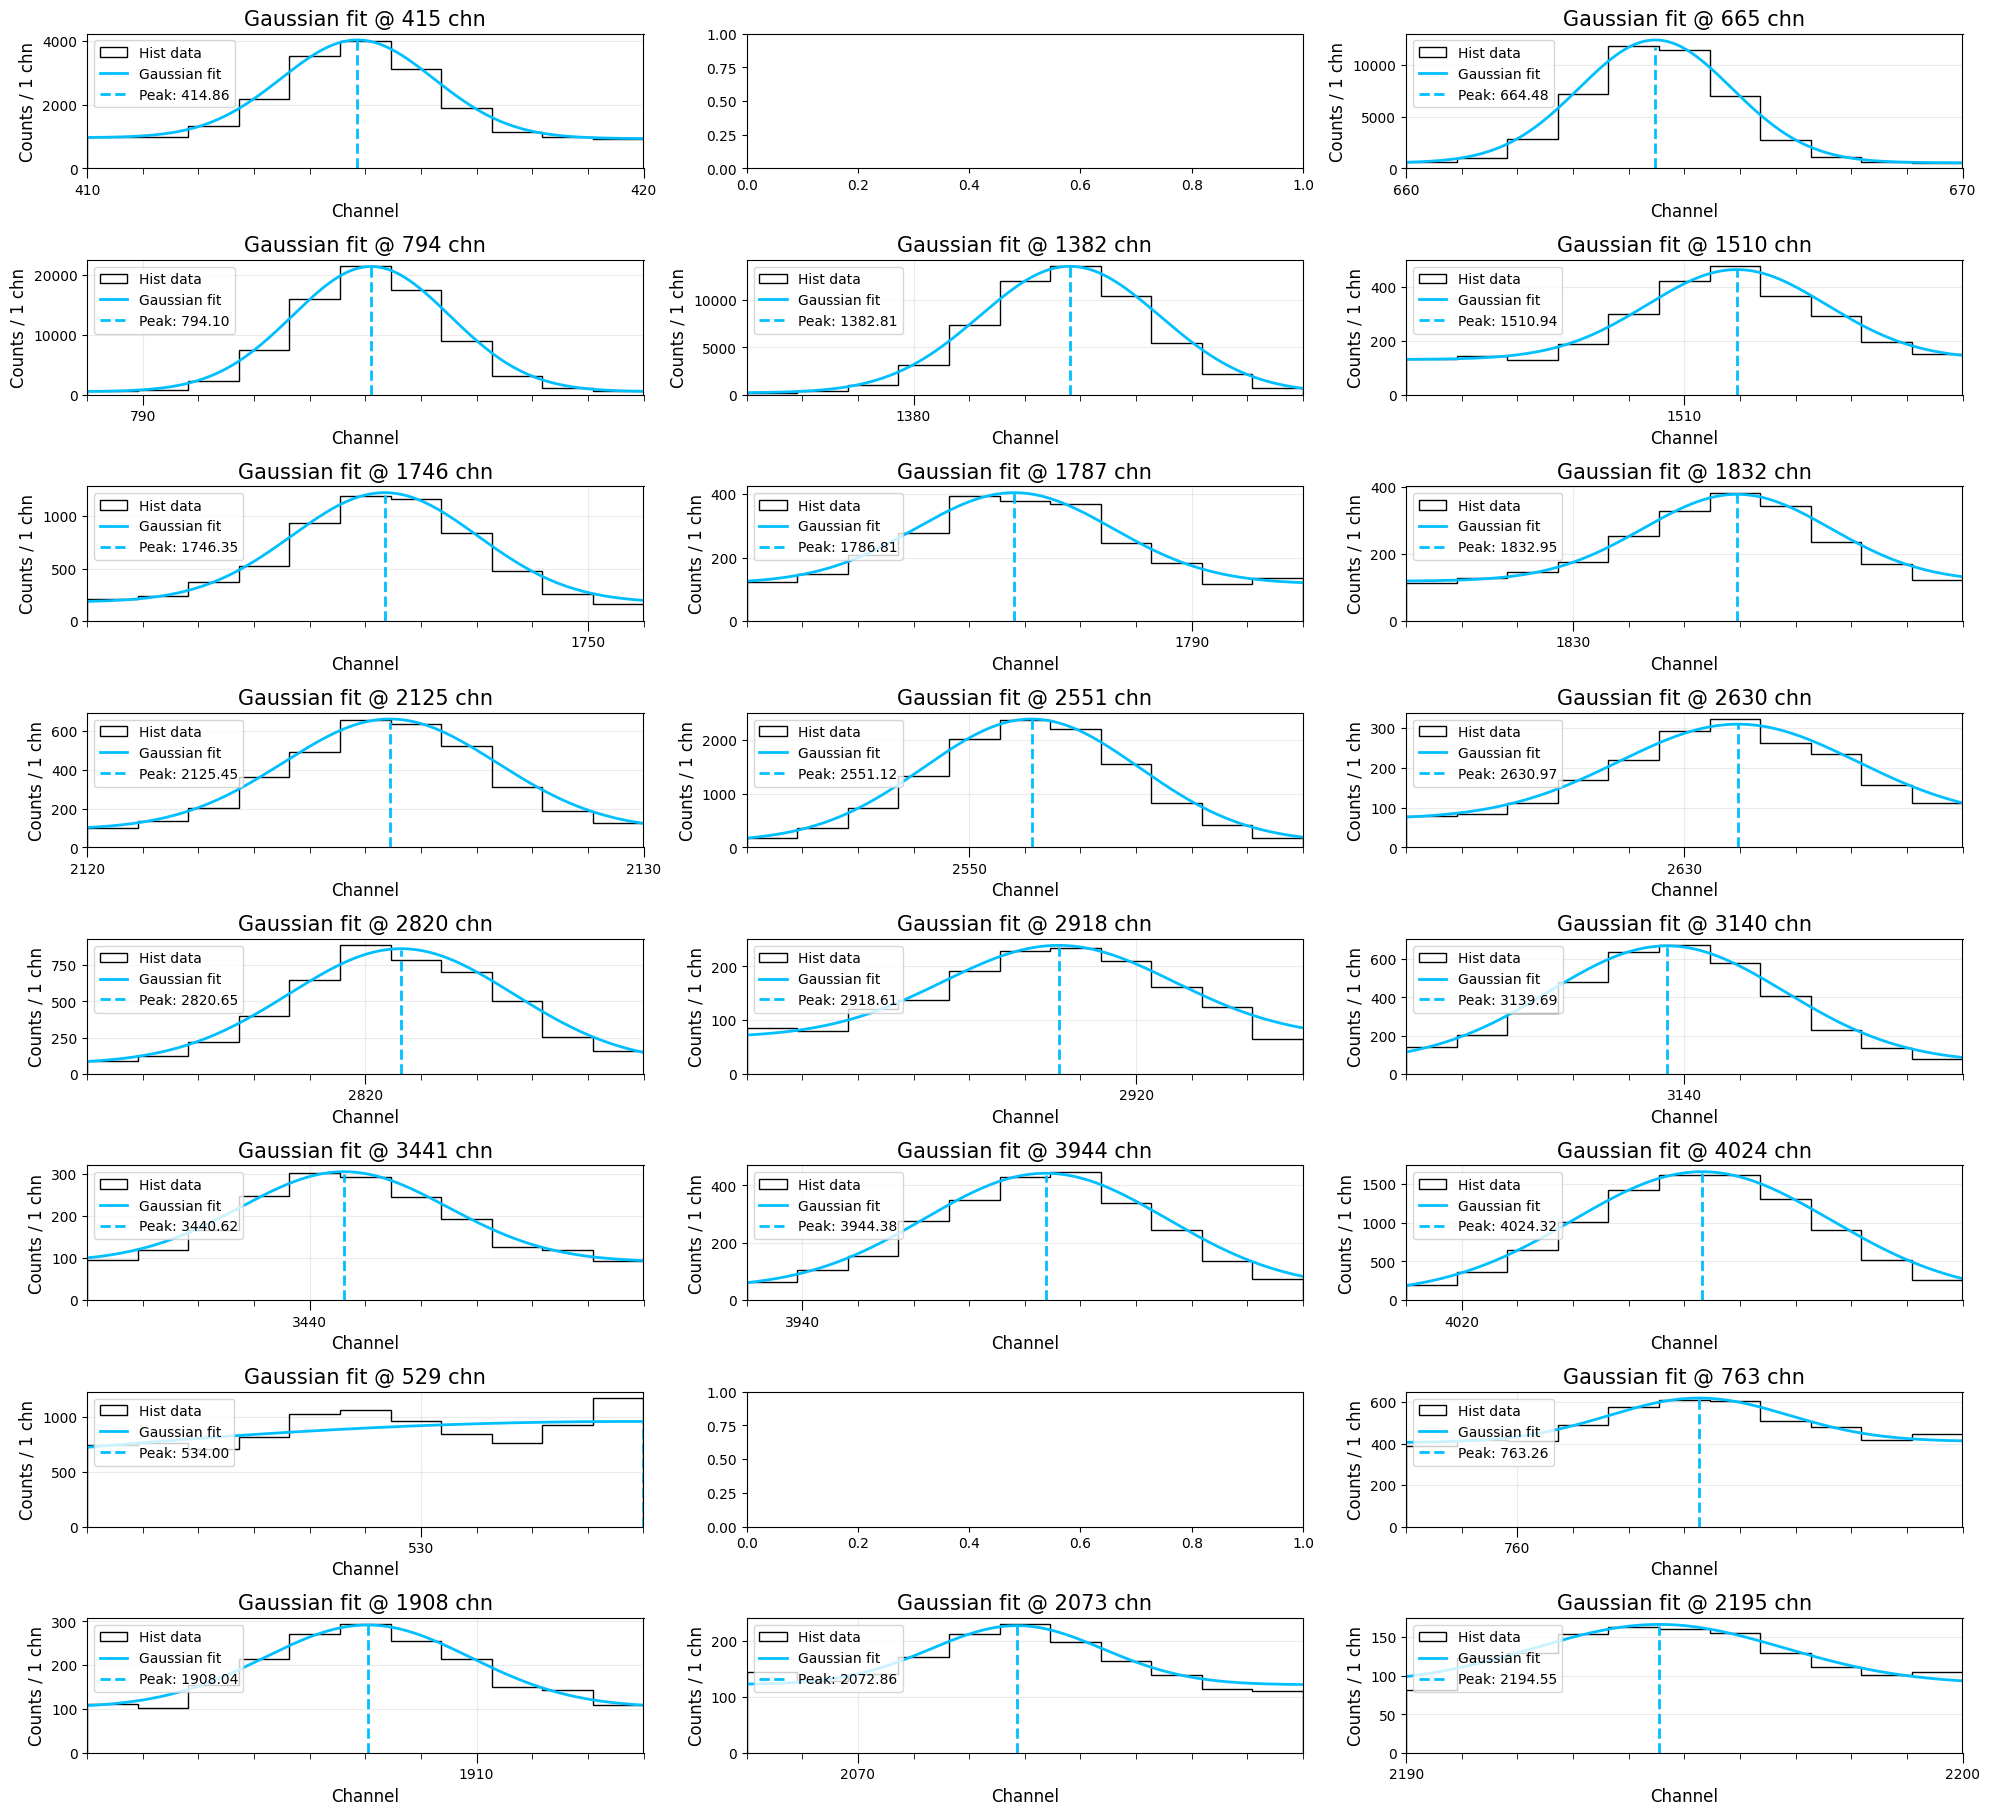

In [516]:
fig, axes = plt.subplots(9, 3, figsize=(20, 20))  # 10 subplot totali

popts_U = []
err_U = []

axes = axes.flatten()  # Rende la matrice 2D in un array 1D per iterare più facilmente

for i, e in enumerate(E_chn_tot):
    if e < 530 or e > 565:
        #print(i)
        ax = axes[i]
        if e == 535.2102857142858:
            dx = 2
        else:
            dx = 5
        popt, err, _ = fit_func(spectrum_U, e, dx=dx, ax=ax)
        popts_U.append(popt)
        err_U.append(err)

# Rimuove i subplot vuoti
for j in range(len(E_chn_tot), len(axes)):
    fig.delaxes(axes[j])

popts_U = np.vstack(popts_U)
err_U = np.vstack(err_U)

plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()


In [517]:
mask_2gauss = (chn > 515) & (chn < 565)

chn_2g = chn[mask_2gauss]
spectrum_2g = spectrum_U[mask_2gauss] 

In [518]:
def triple_gauss_offset(x,
                        A1, mu1, sigma1,
                        A2, mu2, sigma2,
                        A3, mu3, sigma3,
                        offset):
    return (offset +
            A1 * np.exp(- (x - mu1)**2 / (2*sigma1**2)) +
            A2 * np.exp(- (x - mu2)**2 / (2*sigma2**2)) +
            A3 * np.exp(- (x - mu3)**2 / (2*sigma3**2)) )



[4.10144691e+02 5.28888990e+02 1.44464666e+00 5.69971375e+02
 5.34803497e+02 1.42876858e+00 4.92542446e+03 5.42646293e+02
 1.34455579e+00 6.68170014e+02]


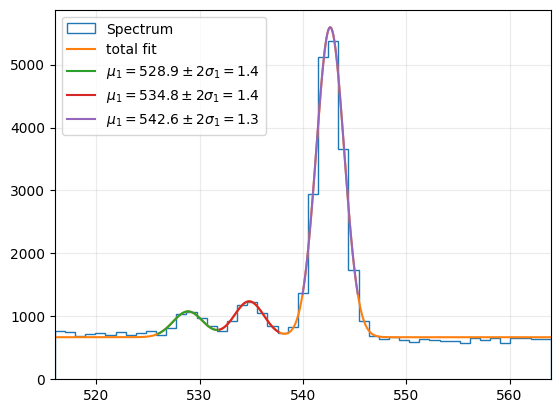

In [519]:

p0 = [1000, 525, 1, 
      1000, 535, 1,
      2000, 543, 1,
      100]

bounds = ([0,0.9*525,0,
          0,0.9*535,0,
          0,0.9*543,0,
          0],
         [10000,1.1*525,50,
         10000,1.1*535,50,
         10000,1.1*543,50,
         100000])

popt, pcov = curve_fit(triple_gauss_offset,
                       chn_2g, spectrum_2g,
                       p0=p0, bounds = bounds)
perr = np.sqrt(np.diag(pcov))
# popt contiene i valori ottimizzati dei 10 parametri
A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, offset = popt
bins =  np.linspace(min(chn_2g), max(chn_2g), len(chn_2g) +1 )
counts, bin_edge, _ = plt.hist(chn_2g, bins = bins, weights = spectrum_2g,  histtype='step', label = 'Spectrum' )
db = bin_edge[1]-bin_edge[0]
x  = np.linspace(min(chn_2g), max(chn_2g), 1000)
plt.plot(x, triple_gauss_offset(x, *popt), label = 'total fit')
x1 = x[(x>popt[1]-2*popt[2]) & (x<popt[1]+2*popt[2])]
plt.plot(x1, triple_gauss_offset(x1, *popt), label = rf'$\mu_1 ={popt[1]:.1f} \pm 2\sigma_1 = {popt[2]:.1f} $')
x2 = x[(x>popt[4]-2*popt[5]) & (x<popt[4]+2*popt[5])]
plt.plot(x2, triple_gauss_offset(x2, *popt), label = rf'$\mu_1 ={popt[4]:.1f} \pm 2\sigma_1 = {popt[5]:.1f} $')
x3 = x[(x>popt[7]-2*popt[8]) & (x<popt[7]+2*popt[8])]
plt.plot(x3, triple_gauss_offset(x3, *popt), label = rf'$\mu_1 ={popt[7]:.1f} \pm 2\sigma_1 = {popt[8]:.1f} $')
plt.xlim(min(chn_2g), max(chn_2g))
plt.grid(alpha = 0.25)
plt.legend()
print(popt)

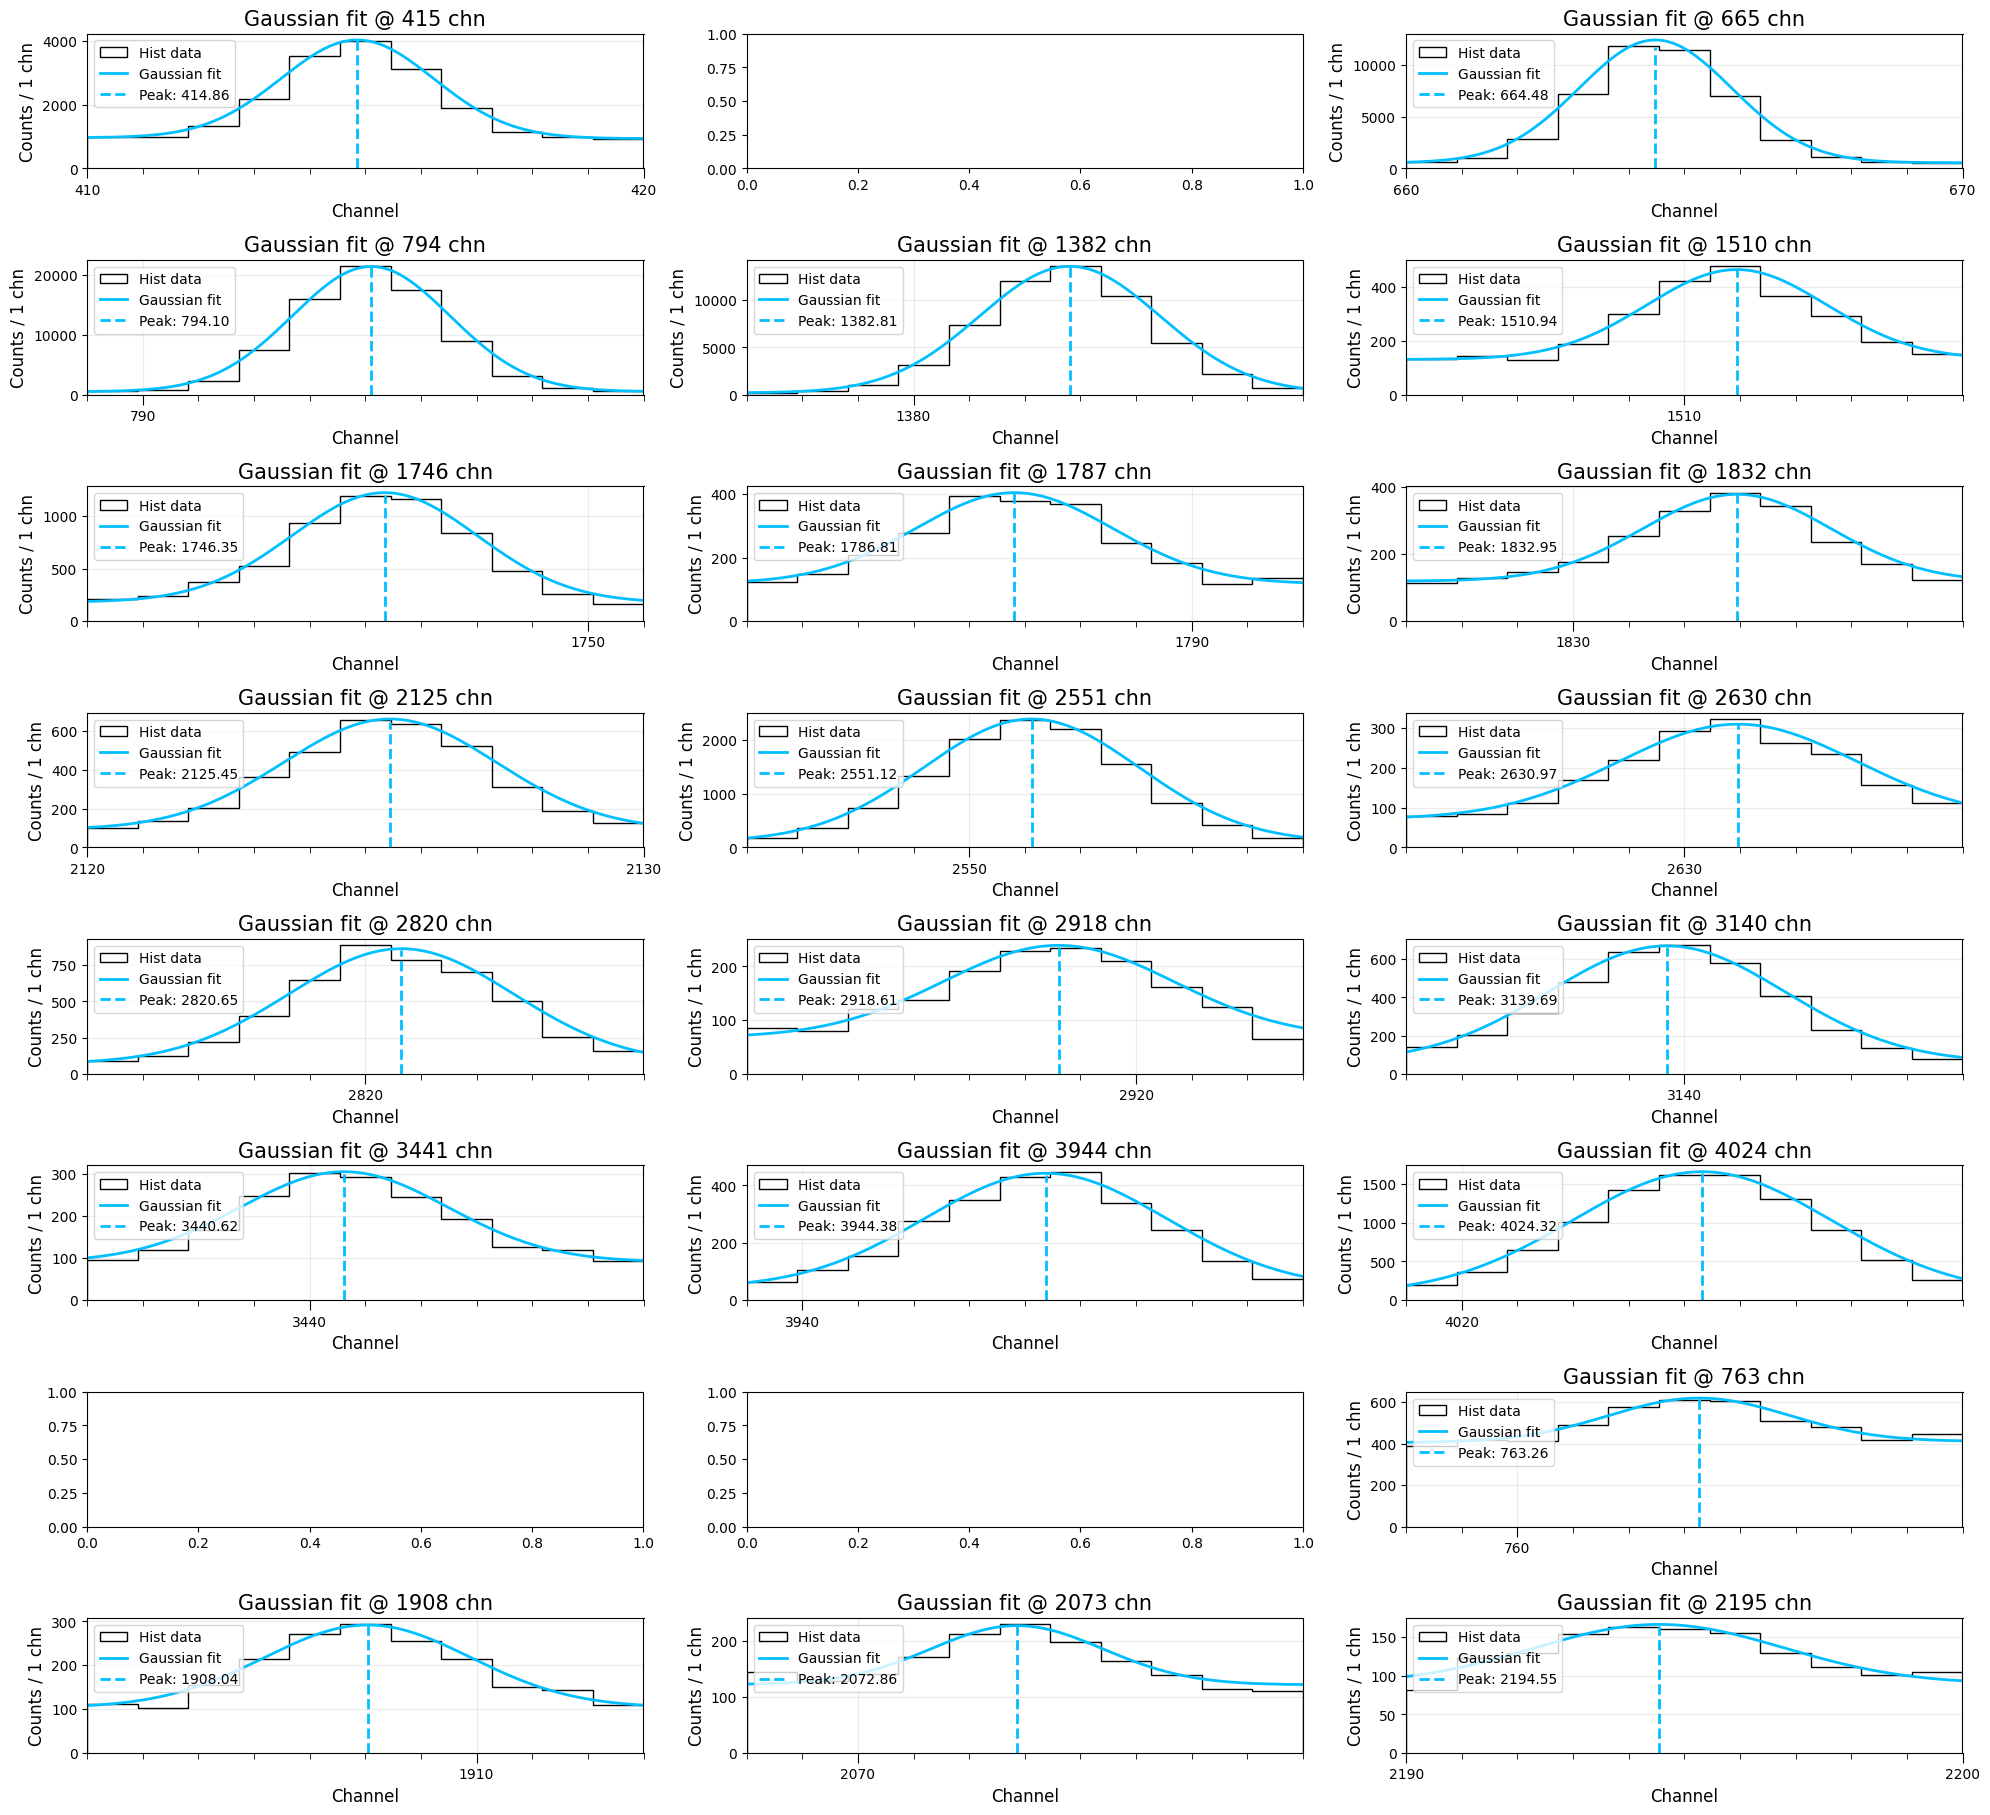

Valori mu finali: [ 414.85897101  528.88899014  664.48015136  794.1044202  1382.80787539
 1510.94236779 1746.3489347  1786.81237418 1832.94792646 2125.44661208
 2551.12089648 2630.96508093 2820.64528665 2918.60768339 3139.68690711
 3440.61834617 3944.37521533 4024.32105242  534.80349737  542.64629251
  763.25830846 1908.03923148 2072.85932958 2194.54769193]
Errori mu finali: [0.01875721 0.16179882 0.01116716 0.00737971 0.00825659 0.09809615
 0.07975812 0.12173541 0.07254406 0.05479419 0.02944827 0.12767444
 0.08271676 0.23448909 0.08045808 0.09949674 0.08654795 0.03582149
 0.11582339 0.01260073 0.17157259 0.15452711 0.18440643 0.38227537]


In [520]:
fig, axes = plt.subplots(9, 3, figsize=(20, 20))  # 27 subplot
axes = axes.flatten()

mu_U = []
err_U = []

# Prima fai il fit triplo per i picchi centrali (una sola volta)
p0 = [1000, 525, 1, 
      1000, 535, 1,
      2000, 543, 1,
      100]

bounds = ([0, 0.9*525, 0,
           0, 0.9*535, 0,
           0, 0.9*543, 0,
           0],
          [10000, 1.1*525, 50,
           10000, 1.1*535, 50,
           10000, 1.1*543, 50,
           100000])

popt, pcov = curve_fit(triple_gauss_offset, chn_2g, spectrum_2g, p0=p0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))

# Estrai e ordina i mu e gli errori
mu_vals = [popt[1], popt[4], popt[7]]
mu_errs = [perr[1], perr[4], perr[7]]
mu_err_pairs = sorted(zip(mu_vals, mu_errs), key=lambda x: x[0])
sorted_mu_vals, sorted_mu_errs = zip(*mu_err_pairs)

# Ora ciclo su tutti i picchi
for i, e in enumerate(E_chn_tot):
    ax = axes[i]
    
    # Se picco nel range 525-555, prendi mu e err dal fit triplo (ordinati)
    if 525 <= e <= 555:
        # Trova quale mu del fit triplo corrisponde a questo picco
        # Presupponiamo che gli e in E_chn_tot nell'intervallo 525-555 corrispondano ai mu in sorted_mu_vals
        # Quindi associamo in ordine crescente:
        # Per farlo, cerchiamo l'indice corrispondente nel sottoinsieme di picchi nel range
        # Crea lista dei picchi in range
        peaks_in_range = [x for x in E_chn_tot if 525 <= x <= 555]
        idx_in_range = peaks_in_range.index(e)  # posizione del picco in questo sottoinsieme
        
        mu_U.append(sorted_mu_vals[idx_in_range])
        err_U.append(sorted_mu_errs[idx_in_range])
        
    else:
        dx = 2 if e == 535.2102857142858 else 5
        popt_single, err_single, _ = fit_func(spectrum_U, e, dx=dx, ax=ax)
        mu_U.append(popt_single[1])
        err_U.append(err_single[1])

# Rimuove subplot vuoti
for j in range(len(E_chn_tot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()

mu_U = np.array(mu_U)
err_U = np.array(err_U)

print("Valori mu finali:", mu_U)
print("Errori mu finali:", err_U)


In [521]:
len(mu_U)

24

Uncertainty on a: 0.000308, on b: 0.68


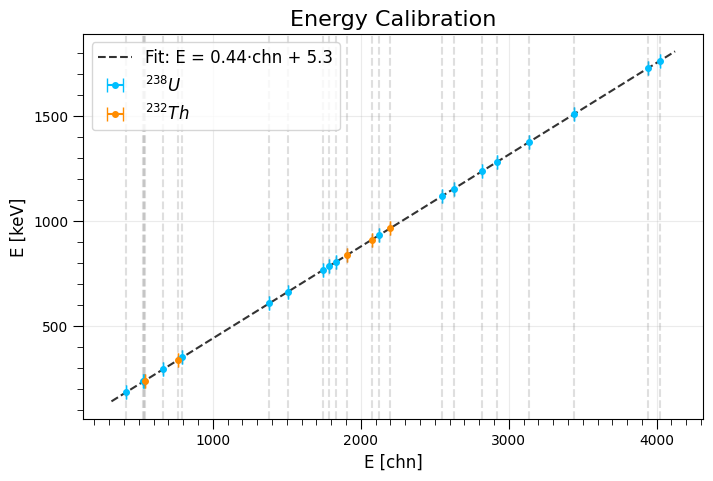

In [541]:
mu_chn = mu_U
mu_chn_err = err_U
plt.figure(figsize=(8, 5))




dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

dx = 500
dy = 100
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.yaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='y', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='y', which='minor', length=4, labelsize=0)   # tacche piccole, no numero







plt.errorbar( mu_chn[:-5],E_kev_tot[:-5], xerr=mu_chn_err[:-5], fmt='o', color = 'deepskyblue', markersize = 4, capsize=5, label=r'$^{238}U$')
plt.errorbar( mu_chn[-5:],E_kev_tot[-5:], xerr=mu_chn_err[-5:], fmt='o', color = 'darkorange',markersize = 4,  capsize=5, label=r'$^{232}Th$')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, mu_chn, E_kev_tot, p0=p0 )
# Incertezze
perr_U = np.sqrt(np.diag(pcov))
print(f"Uncertainty on a: {perr_U[0]:.6f}, on b: {perr_U[1]:.2f}")
a = popt[0]
b = popt[1]

# Plot
x_fit = np.linspace(min(mu_chn)-100, max(mu_chn)+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)
for chn in E_chn_tot:
    plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.25)
plt.legend(fontsize = 12, loc = 'upper left' )
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("HPGe images/238U/E_ene_cal", dpi=300, bbox_inches='tight')

In [542]:
channels = np.arange(len(spectrum_U))         # x originale
energies = a * channels + b

In [543]:
print('b', perr_U[1])
print('b bkg', b_bkg)
print('a', perr_U[0])
print('a bkg', a_bkg)

b 0.6810417980058685
b bkg 4.682979221543532
a 0.00030830826551090425
a bkg 0.4373829474144022


[4.10144608e+02 2.36507741e+02 6.31480322e-01 5.69971401e+02
 2.39093074e+02 6.24539391e-01 4.92542447e+03 2.42521296e+02
 5.87728584e-01 6.68170007e+02]


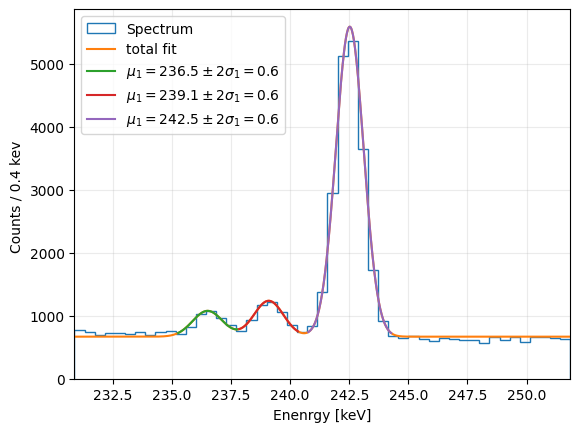

In [544]:
ene_2g = energies[mask_2gauss]
bins =  np.linspace(min(ene_2g), max(ene_2g), len(ene_2g) +1 )
counts, bin_edge, _ = plt.hist(ene_2g, bins = bins, weights = spectrum_2g,  histtype='step', label = 'Spectrum' )
db = bin_edge[1]-bin_edge[0]

# Prima fai il fit triplo per i picchi centrali (una sola volta)
p0 = [1000, 238, 0.5, 
      1000, 240, 0.5,
      2000, 242, 0.5,
      100]

bounds = ([0, 0.95*238, 0,
           0, 0.95*240, 0,
           0, 0.95*242, 0,
           0],
          [10000, 1.05*238, 5,
           10000, 1.05*240, 5,
           10000, 1.05*242, 5,
           100000])

popt, pcov = curve_fit(triple_gauss_offset, ene_2g, spectrum_2g, p0=p0, bounds = bounds)
perr = np.sqrt(np.diag(pcov))
x  = np.linspace(min(ene_2g), max(ene_2g), 1000)
plt.plot(x, triple_gauss_offset(x, *popt), label = 'total fit')
x1 = x[(x>popt[1]-2*popt[2]) & (x<popt[1]+2*popt[2])]
plt.plot(x1, triple_gauss_offset(x1, *popt), label = rf'$\mu_1 ={popt[1]:.1f} \pm 2\sigma_1 = {popt[2]:.1f} $')
x2 = x[(x>popt[4]-2*popt[5]) & (x<popt[4]+2*popt[5])]
plt.plot(x2, triple_gauss_offset(x2, *popt), label = rf'$\mu_1 ={popt[4]:.1f} \pm 2\sigma_1 = {popt[5]:.1f} $')
x3 = x[(x>popt[7]-3*popt[8]) & (x<popt[7]+3*popt[8])]
plt.plot(x3, triple_gauss_offset(x3, *popt), label = rf'$\mu_1 ={popt[7]:.1f} \pm 2\sigma_1 = {popt[8]:.1f} $')
plt.xlim(min(ene_2g), max(ene_2g))
plt.grid(alpha = 0.25)
plt.xlabel('Enenrgy [keV]')
plt.ylabel(f'Counts / {db:.1f} kev ')
plt.legend()
print(popt)

In [545]:
popt

array([4.10144608e+02, 2.36507741e+02, 6.31480322e-01, 5.69971401e+02,
       2.39093074e+02, 6.24539391e-01, 4.92542447e+03, 2.42521296e+02,
       5.87728584e-01, 6.68170007e+02])

In [546]:
len(E_kev_tot)

24

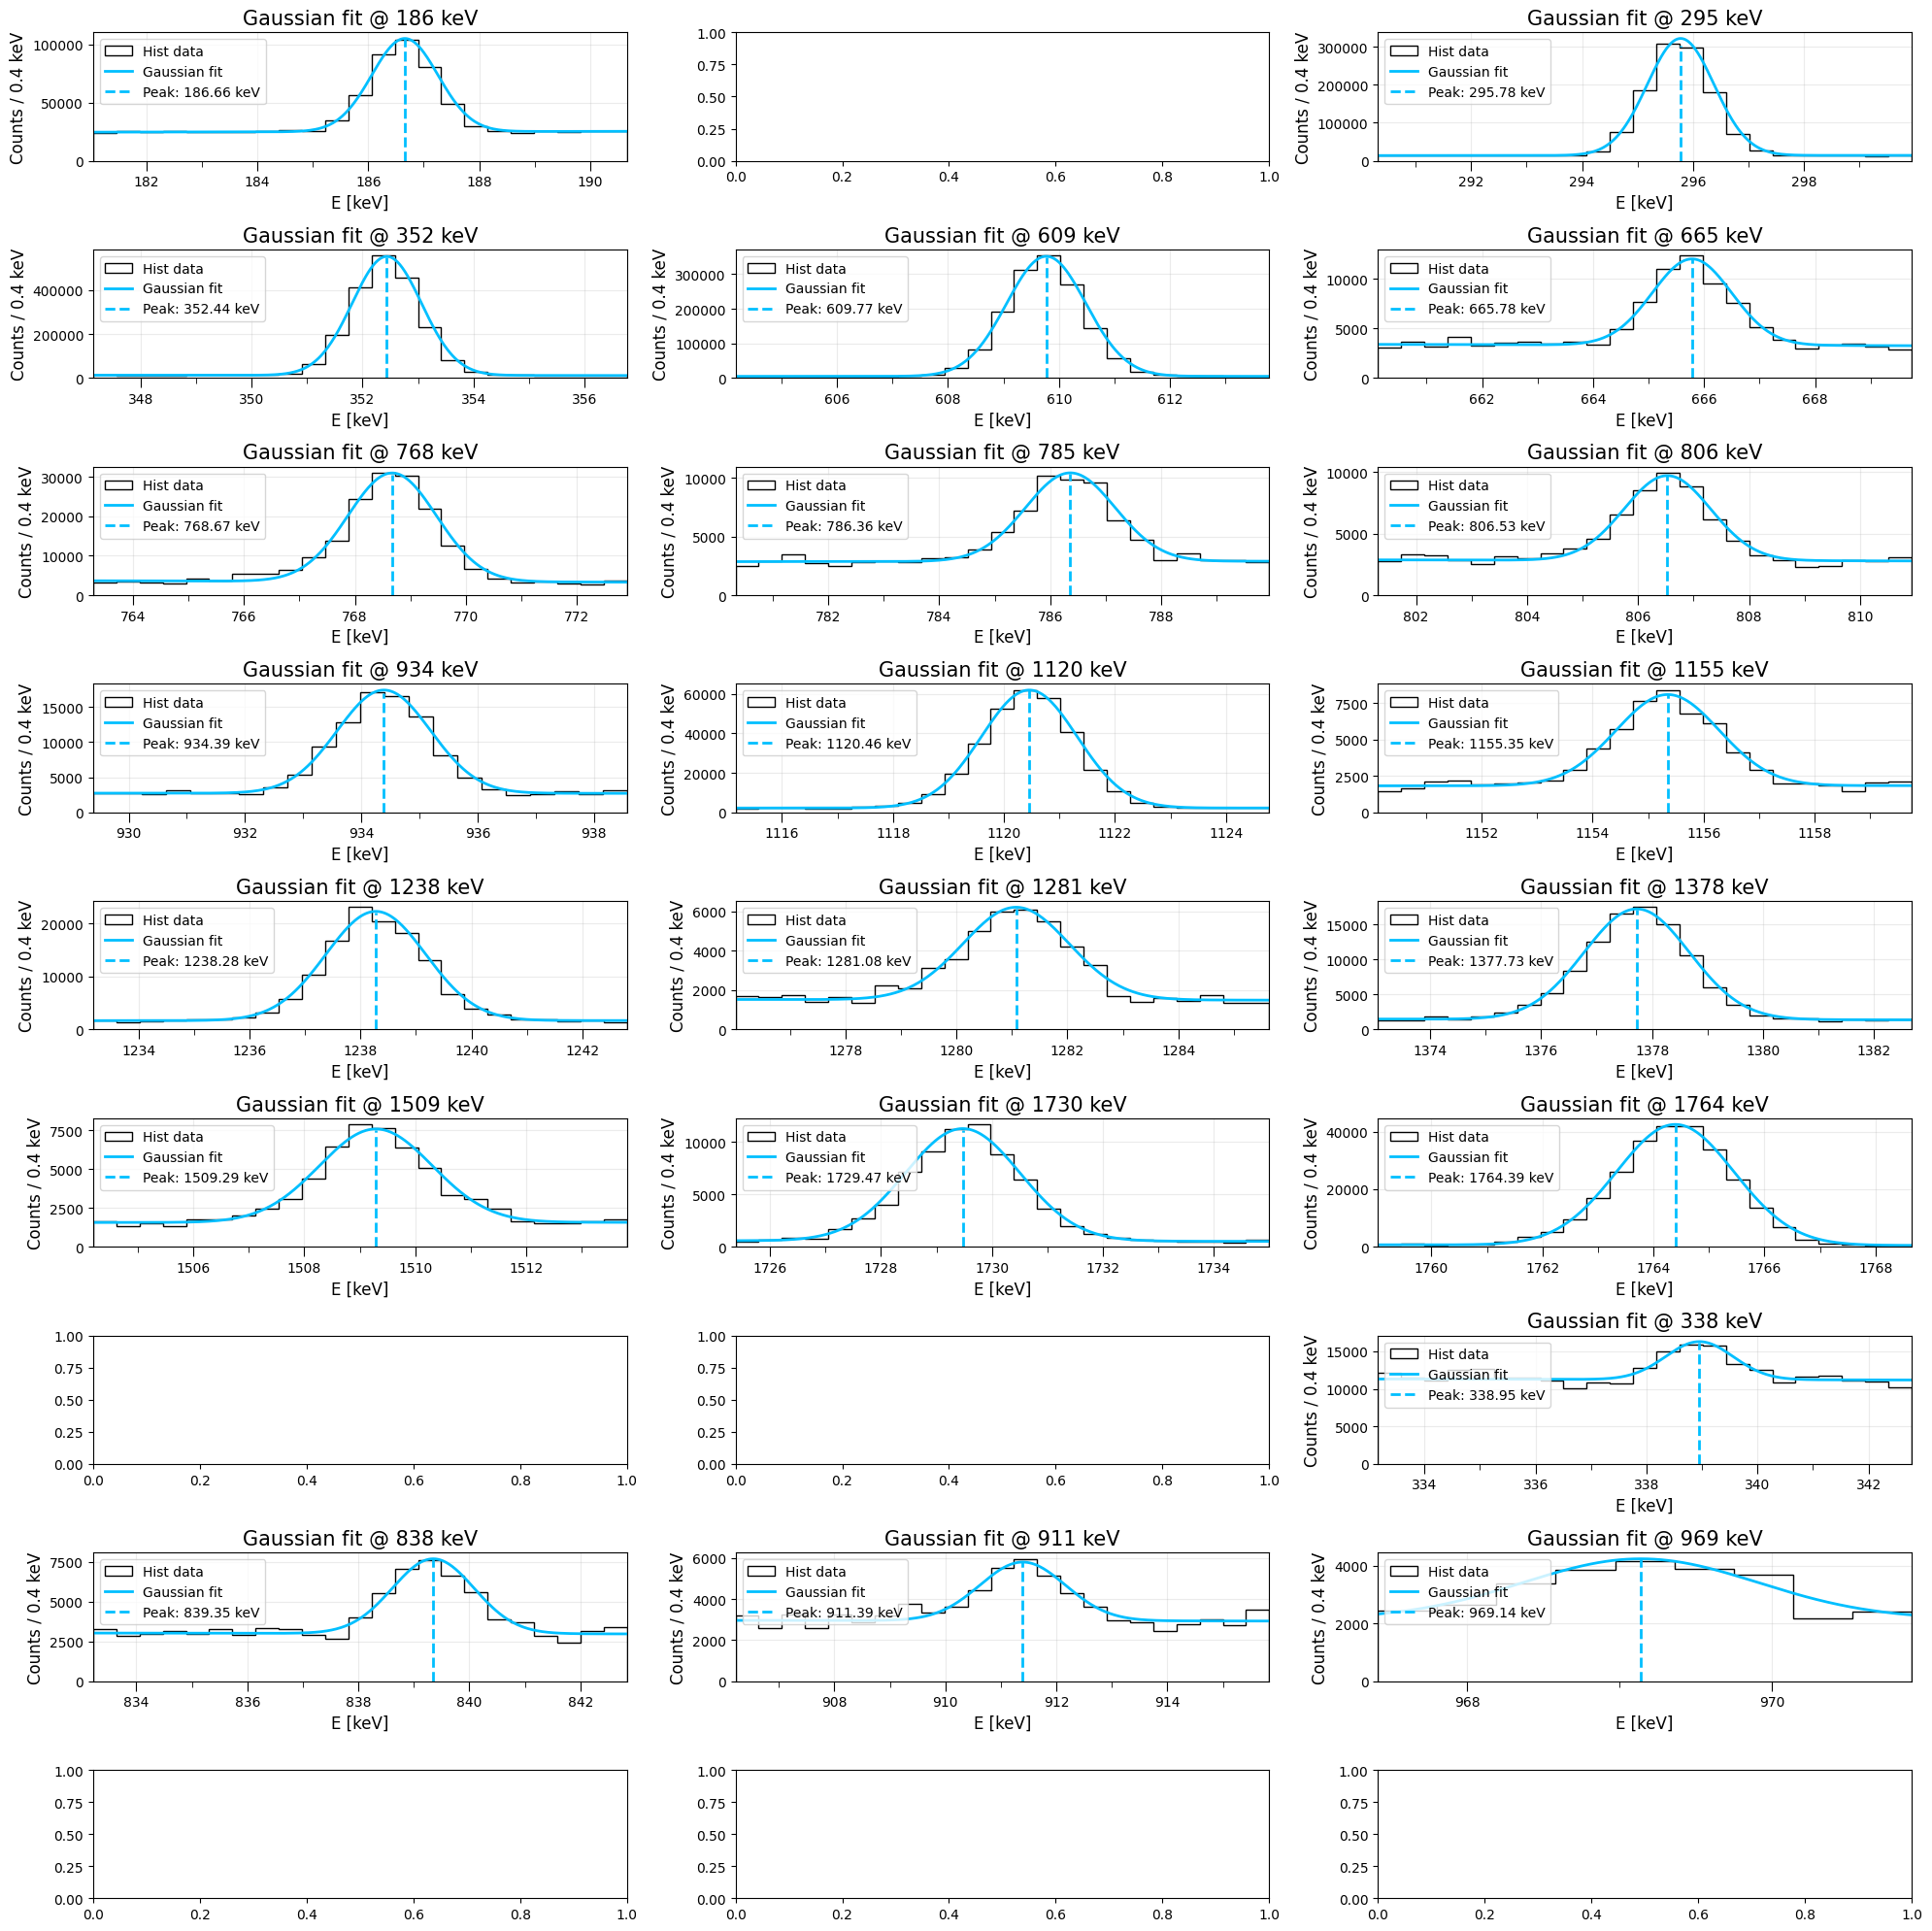

Valori mu finali: [ 186.65874676  236.50774083  295.77702167  352.43902255  609.77151708
  665.78320773  768.67214246  786.36244949  806.52795118  934.38888768
 1120.45573918 1155.35292469 1238.27718229 1281.07774892 1377.72659458
 1509.29111017 1729.47233888 1764.3944949   239.09307428  242.52129561
  338.95297352  839.35048199  911.39497077  969.13858439]
Errori mu finali: [0.00706127 0.0707251  0.00375569 0.00505657 0.00632178 0.03532735
 0.0318741  0.03644126 0.03825679 0.0195207  0.01065414 0.04141874
 0.02013177 0.05390337 0.02196608 0.041198   0.02280932 0.01997015
 0.0506284  0.005508   0.08509745 0.05356323 0.08276223 0.158586  ]
Valori sigma finali: [0.59705517 0.63148032 0.60152457 0.62506806 0.71530328 0.71564286
 0.79786895 0.80866626 0.78093915 0.80299297 0.86113803 0.93103193
 0.8995892  0.95630681 0.94973547 1.01807203 1.0302092  1.05986872
 0.62453939 0.58772858 0.60833126 0.73736759 0.77129941 0.7687806 ]
Errori sigma finali: [0.00675971 0.07523668 0.00316557 0.004089

In [547]:
mu_U_kev = []
err_mu_U_kev = []
sigma_U_kev = []
err_sigma_U_kev = []

# Fit triplo
p0 = [1000, 238, 0.5, 
      1000, 240, 0.5,
      2000, 242, 0.5,
      100]

bounds = ([0, 0.95*238, 0,
           0, 0.95*240, 0,
           0, 0.95*242, 0,
           0],
          [10000, 1.05*238, 5,
           10000, 1.05*240, 5,
           10000, 1.05*242, 5,
           100000])

popt, pcov = curve_fit(triple_gauss_offset, ene_2g, spectrum_2g, p0=p0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))

# estrai e ordina mu e sigma con errori
mu_vals = [popt[1], popt[4], popt[7]]
sigma_vals = [popt[2], popt[5], popt[8]]
mu_errs = [perr[1], perr[4], perr[7]]
sigma_errs = [perr[2], perr[5], perr[8]]

mu_err_pairs = sorted(zip(mu_vals, mu_errs, sigma_vals, sigma_errs), key=lambda x: x[0])
sorted_mu_vals, sorted_mu_errs, sorted_sigma_vals, sorted_sigma_errs = zip(*mu_err_pairs)
fig, axes = plt.subplots(9, 3, figsize=(20, 20))  # 27 subplot
axes = axes.flatten()
# ciclo sui picchi
for i, e in enumerate(E_kev_tot):
    ax = axes[i]
    
    if 220 <= e <= 250:
        peaks_in_range = [x for x in E_kev_tot if 220 <= x <= 250]
        idx_in_range = peaks_in_range.index(e)
        
        mu_U_kev.append(sorted_mu_vals[idx_in_range])
        err_mu_U_kev.append(sorted_mu_errs[idx_in_range])
        sigma_U_kev.append(sorted_sigma_vals[idx_in_range])
        err_sigma_U_kev.append(sorted_sigma_errs[idx_in_range])
        
    else:
        if e == E_kev_tot[-1]:
            dx = 2
        else:
            dx = 5
        popt_single, err_single, _ = fit_func(spectrum_U, e, dx=dx, kev=True, energies=energies, ax=ax)
        
        mu_U_kev.append(popt_single[1])
        err_mu_U_kev.append(err_single[1])
        sigma_U_kev.append(popt_single[2])        # sigma
        err_sigma_U_kev.append(err_single[2])     # errore sigma


plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()

mu_U_kev = np.array(mu_U_kev)
err_mu_U_kev = np.array(err_mu_U_kev)
sigma_U_kev = np.array(sigma_U_kev)
err_sigma_U_kev = np.array(err_sigma_U_kev)

print("Valori mu finali:", mu_U_kev)
print("Errori mu finali:", err_mu_U_kev)
print("Valori sigma finali:", sigma_U_kev)
print("Errori sigma finali:", err_sigma_U_kev)


incertezza grandi solo 3 punti del fit
paramters: [7.33256375e-02 3.96850520e-16]
Errori: [4.10610460e-03 4.93411277e+01]


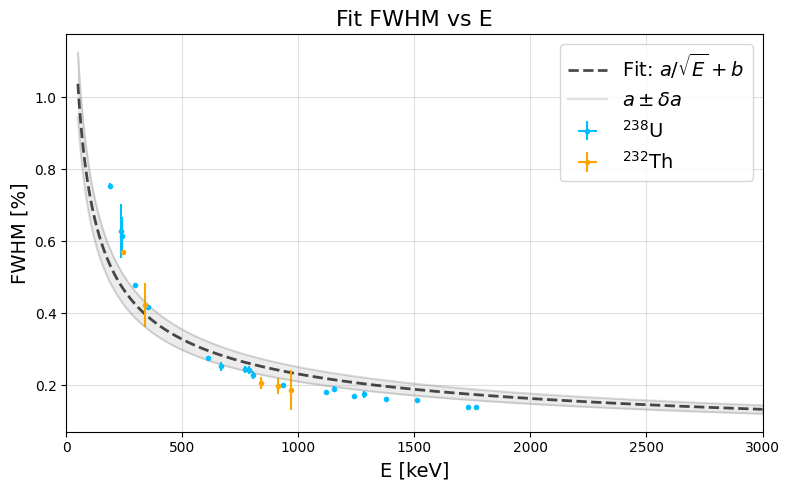

In [548]:


sigma=sigma_U_kev
sigma_err_kev =err_sigma_U_kev
mu_kev=mu_U_kev
mu_kev_err=err_mu_U_kev
# Calcolo FWHM e incertezza
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
FWHM_err = FWHM_err
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,100])
p0=[0.1,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err, p0=p0, bounds=boundary)
perr_U_res = np.sqrt(np.diag(pcov))
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit,*popt )*100, label=r'Fit: $a/\sqrt{E} + b$ ', color='black', ls = '--', alpha = 0.7, lw=2)
# Dati con errore su x e y, e stile pallini
# Fino al -5: Uranio
plt.errorbar(mu_kev[:-5], FWHM[:-5] * 100,
             xerr=mu_kev_err[:-5],
             yerr=FWHM_err[:-5]* 100,
             fmt='o',
             color='deepskyblue',
             markersize=3,
             label=r'$^{238}$U')

# Ultimi 5: Torio
plt.errorbar(mu_kev[-5:], FWHM[-5:] * 100,
             xerr=mu_kev_err[-5:],
             yerr=FWHM_err[-5:]* 100,
             fmt='o',
             color='orange',
             markersize=3,
             label=r'$^{232}$Th')

upper_curve = fhwm_func(E_fit, popt[0] + 1.5*perr_U_res[0], popt[1]) * 100
lower_curve = fhwm_func(E_fit, popt[0] - 1.6*perr_U_res[0], popt[1]) * 100

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.25, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.25)
a_res_U = popt[0]
b_res_U  = popt[1]
# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.title('Fit FWHM vs E',  size = 16)
plt.xlim(0,3000)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("HPGe images/238U/ FWHM_U", dpi=300, bbox_inches='tight')
plt.show()

# Subtracted Spectrum

In [549]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_bkg = data[0].values

# correggo col dead time il background
t_live_b = 76747
t_real_b = 76752
# correggo subito per il tempo morto
D_b = 1-(t_live_b/t_real_b)

spectrum_bkg = spectrum_bkg/D_b

In [550]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625
# correggo subito per il tempo morto
D_u = 1-(t_live_u/t_real_u)

spectrum_U = spectrum_U/D_u

In [551]:
Utime = 625 #s
bkg_time = 76752 #s

conversion = Utime/bkg_time

In [552]:
spectrum_bkg_norm = spectrum_bkg*conversion

In [553]:
spectrum_fin = spectrum_U-spectrum_bkg_norm

In [554]:
len(spectrum_fin)

8192

In [555]:
chn = np.linspace(0, len(spectrum_fin), len(spectrum_fin))
energies = chn*a + b

## X-ray peaks below 240 keV

In [556]:
x_peaks_uranio = {
    72.8: 'Lβ₂',
    74.97: 'Lβ₁',
    77.16: 'Lβ₃',
    84.6: 'Lγ₁',
    87.2: 'Lγ₂/γ₃',
}


In [557]:
import matplotlib.pyplot as plt
from pastamarkers import pasta, salsa


73.5198417230698
75.70569499231732
77.89154826156484
85.3234493770064
87.94647330010342
90.56949722320044
93.19252114629747
95.37837441554498
99.31291030019051
111.9908592618261
115.05105383877263


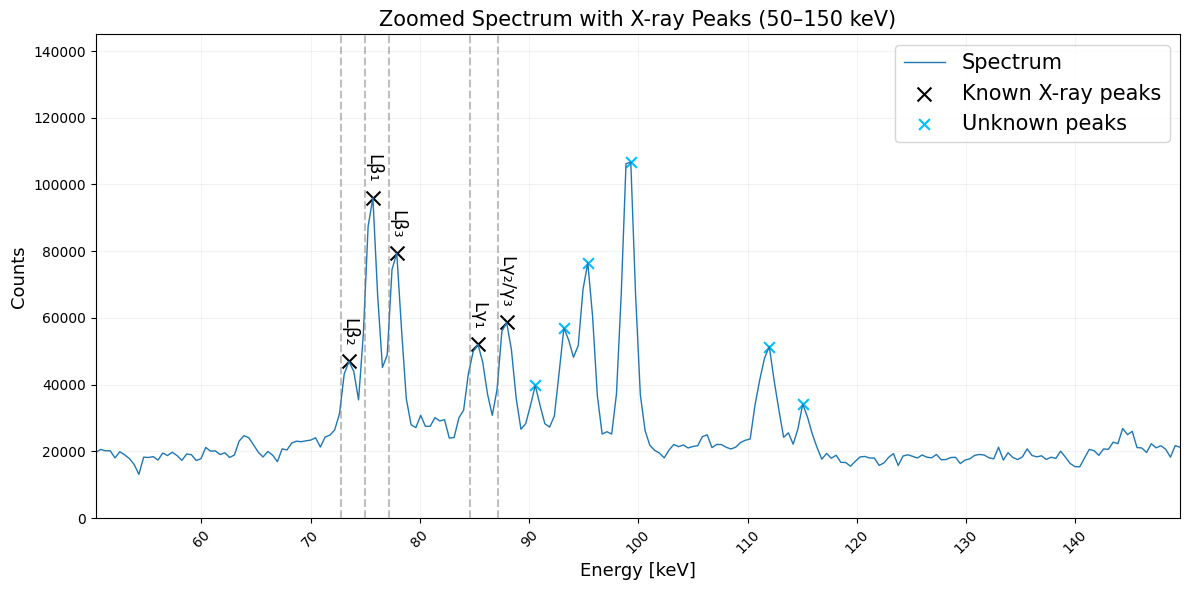

In [558]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Maschera per lo zoom nello spettro (50 keV < E < 150 keV)
mask = (energies > 50) & (energies < 150)
energies_X = energies[mask]
spec_X = spectrum_fin[mask]

# Trova picchi sopra soglia
peaks, properties = find_peaks(spec_X, height=3.1e4)

# Picchi noti dell’Uranio (serie L)
x_peaks_uranio = {
    72.8: 'Lβ₂',
    74.97: 'Lβ₁',
    77.16: 'Lβ₃',
    84.6: 'Lγ₁',
    87.2: 'Lγ₂/γ₃',
}

tolerance = 1.0

# Flag per mostrare label una sola volta
plotted_known = False
plotted_unknown = False

# Plot dello spettro
plt.figure(figsize=(12, 6))
plt.plot(energies_X, spec_X, linewidth=1, label='Spectrum')
plt.xlabel('Energy [keV]',fontsize=13)
plt.ylabel('Counts', fontsize=13)
plt.title('Zoomed Spectrum with X-ray Peaks (50–150 keV)', fontsize=15)
plt.xticks(np.arange(50, 151, 10), rotation=45)
plt.xlim(min(energies_X), max(energies_X))
plt.ylim(0, 14.5e4)

# Loop su tutti i picchi
for p in peaks:
    energy_p = energies_X[p]
    count_p = spec_X[p]
    print(energy_p)
    
    
    # Verifica se è un picco noto dell’Uranio
    matched = False
    for ref_energy, label in x_peaks_uranio.items():
        if abs(energy_p - ref_energy) < tolerance:
            matched = True
            plt.scatter(energy_p, count_p, color='black', marker='x', s=100,
                        label='Known X-ray peaks' if not plotted_known else "")
            plt.text(energy_p, count_p + 4500,
                     f'{label}',
                     fontsize=13, rotation=270, ha='center', va='bottom')
            plotted_known = True
            break

    # Se non è un picco noto → unknown
    if not matched:
        plt.scatter(energy_p, count_p, color='deepskyblue', marker='x', s=60,
                    label='Unknown peaks' if not plotted_unknown else "")
        plotted_unknown = True

# Aggiungi linee tratteggiate per i picchi noti
for ref_energy, label in x_peaks_uranio.items():
    plt.axvline(ref_energy, color='grey', linestyle='--', alpha=0.5)

plt.grid(alpha=0.15)
plt.legend(fontsize = 15)
plt.tight_layout()
plt.savefig("HPGe images/238U/U_energy_spectrum_known_unknown_peaks", dpi=300, bbox_inches='tight')
plt.show()



## Continue activity

(0.0, 3000.0)

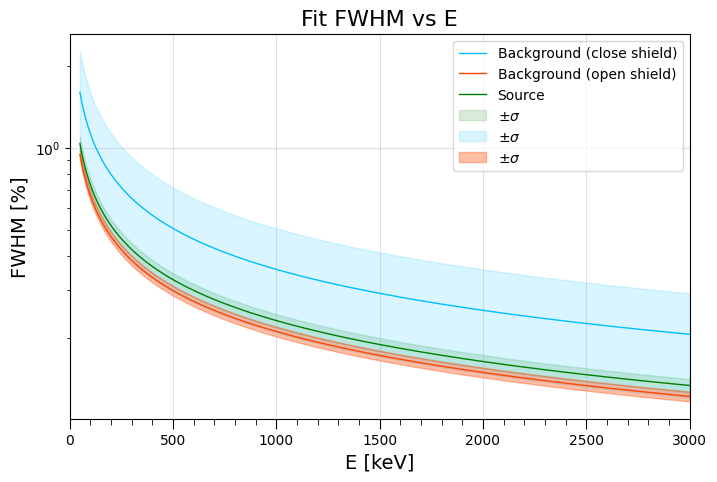

In [559]:
# Parametri per tacche su asse x
dx = 500  # numeri ogni 500 keV
dy = 100  # tacche ogni 100 keV

E_fit = np.linspace(50, 3000, 1000)

plt.figure(figsize=(8, 5))

# === IMPOSTA TICKS X PRIMA DEL PLOT ===
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

plt.plot(E_fit, fhwm_func(E_fit,a_res_bkg, b_res_bkg)*100, lw = 1, color = 'deepskyblue', label=r'Background (close shield)')
plt.plot(E_fit, fhwm_func(E_fit,a_open_res, b_open_res)*100, lw = 1, color = 'orangered', label=r'Background (open shield)')
plt.plot(E_fit, fhwm_func(E_fit,a_res_U, b_res_U)*100, lw = 1, color = 'green',  label = 'Source')
#plt.plot(E_fit, fhwm_func(E_fit,a_res, b_res)*100, label=r'Source - Background')


#curva source
upper_curve = fhwm_func(E_fit,a_res_U + perr_U_res[0],b_res_U) * 100
lower_curve = fhwm_func(E_fit, a_res_U - perr_U_res[0], b_res_U) * 100
plt.fill_between(E_fit, lower_curve, upper_curve, color='green', alpha=0.15, label = r'$\pm \sigma$')


#baclgroung
upper_curve = fhwm_func(E_fit, a_res_bkg + perr_back_res[0], b_res_bkg) * 100
lower_curve = fhwm_func(E_fit, a_res_bkg - perr_back_res[0],b_res_bkg) * 100
plt.fill_between(E_fit, lower_curve, upper_curve, color='deepskyblue', alpha=0.15, label = r'$\pm \sigma$')

#background open
upper_curve = fhwm_func(E_fit,a_open_res + perr_open_res[0], b_open_res)*100
lower_curve = fhwm_func(E_fit,a_open_res - perr_open_res[0], b_open_res)*100
plt.fill_between(E_fit, lower_curve, upper_curve, color='orangered', alpha=0.35, label = r'$\pm \sigma$')


plt.yscale('log')

plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.title('Fit FWHM vs E',  size = 16)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.savefig("HPGe images/ comparison_res", dpi=300, bbox_inches='tight')
plt.xlim(0,3000)

### !!!

Manually creating a bettere enrgy resolution ---> cancelig the widers tails

[Aggiungi]

## Average activity Estimation

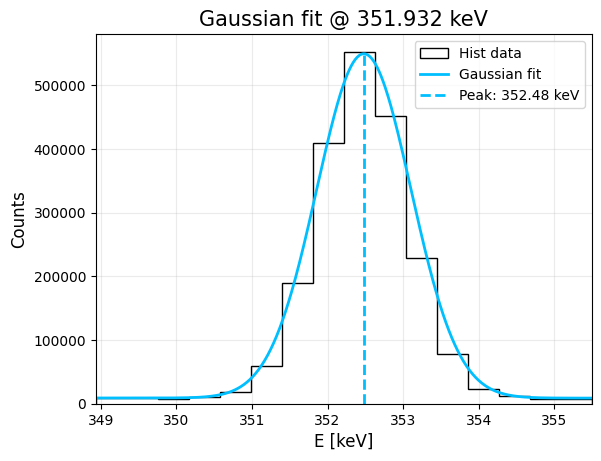

In [560]:

E_214Pb = 295.224
I_214Pb = 0.193

E_214Pb = 241.997
I_214Pb = 0.0743


E_214Pb = 351.932
I_214Pb = 0.376



dx = 3
popt_214, err_214, _ = fit_func_sottratto( spectrum_U, spectrum_bkg_norm, E_214Pb, dx=dx, kev = True, energies= energies)

A_eff = popt_214[0]/(I_214Pb * t_real_u)

# the maximum efficiency is around 5%
eff_max = 0.045

A_max = A_eff/(eff_max)
dA_max = err_214[0]/(I_214Pb * t_real_u)

In [561]:
A_max

np.float64(79771.0302693072)

In [562]:
dA_max

np.float64(23.61169402873699)

# Attività

In [563]:
def potenza(E, a, k):
    return k * np.pow(E, -a)

In [564]:
def linear(x,a,b):
    return -a*x + b

### Lead 214 Pb

In [565]:

E_214Bi = [
    609.312,
    934.061,
    1120.287,
    1238.110,
    1377.669,
    1764.494,
    2204.210
]

I_214Bi = [
    0.461,
    0.0303,
    0.151,
    0.0579,
    0.04,
    0.150,
    0.058
]



E_214Bi =  [2204.21,
            2118.55,
            1847.42,
            1764.49,
            1729.595,
            1661.28,
            1377.669]
I_214Bi = [0.05,
          0.01,
          0.02,
          0.15,
          0.03,
          0.01,
          0.04]

In [566]:
E_214Pb = [ 241.997,
            295.224,
            351.932]

I_214Pb = [ 0.0743,
            0.193,
            0.376]

E_Ra = [ 186.221]

I_Ra = [ 0.0359]


In [567]:
E_tot = []
E_tot.extend(E_Ra)
E_tot.extend(E_214Pb)
E_tot.extend(E_214Bi)
E_tot = np.array(E_tot)


In [568]:
I_tot = []
I_tot.extend(I_Ra)
I_tot.extend(I_214Pb)
I_tot.extend(I_214Bi)
I_tot = np.array(I_tot)

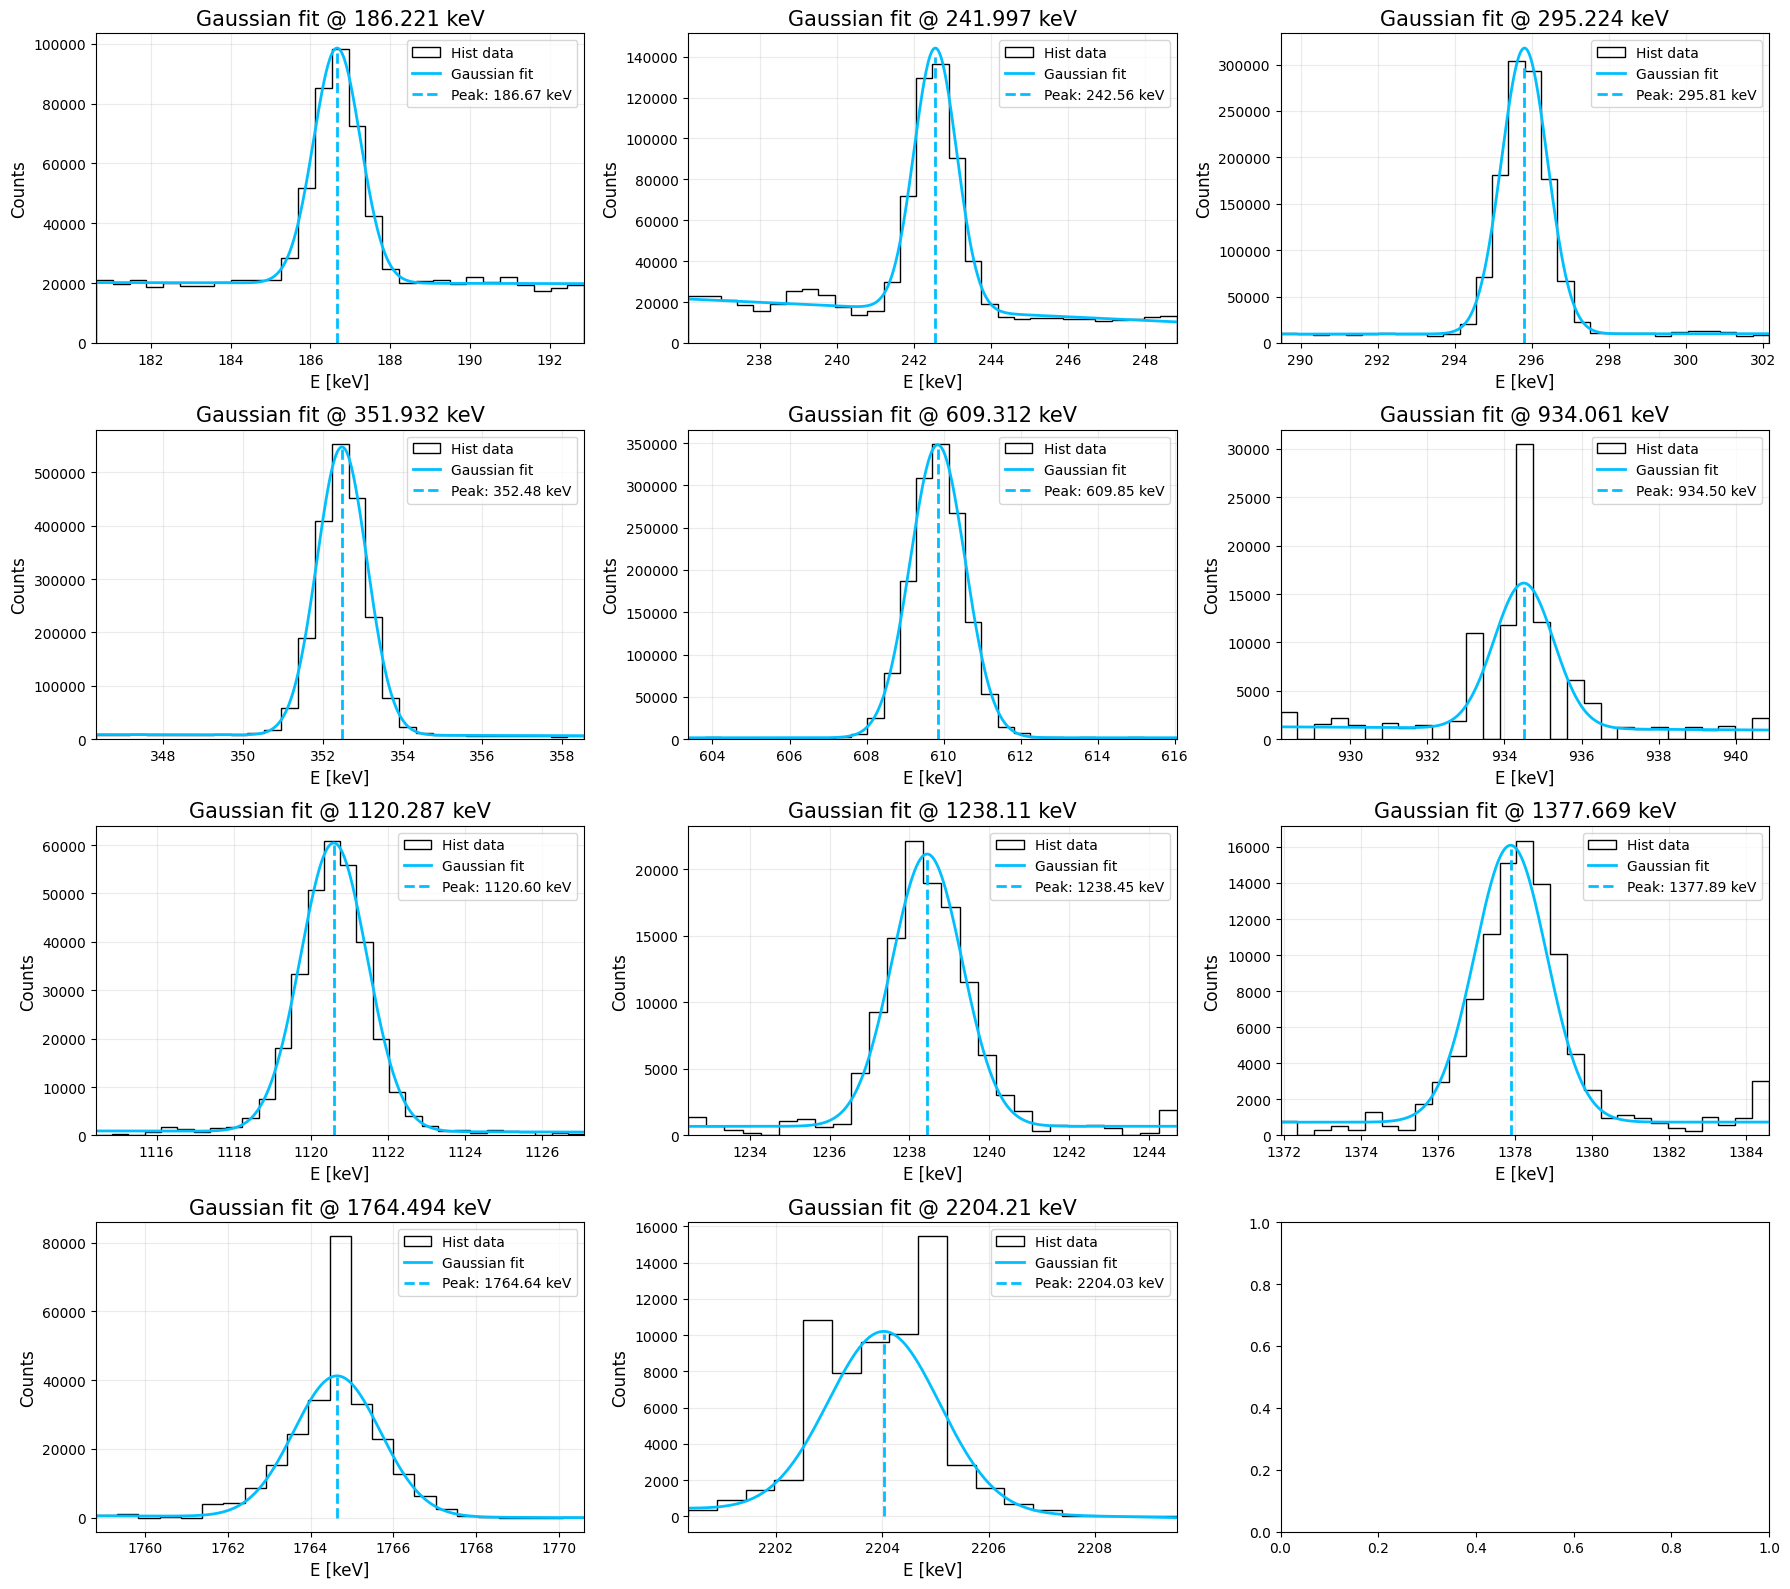

In [569]:
fig, axes = plt.subplots(4, 3, figsize=(18, 16))  # 4 righe, 2 colonne

popts = []
errs = []

for i, e in enumerate(E_tot):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    if i == 7:
        dx = 6
    else:
        dx = 6
    popt, err, _ = fit_func_sottratto( spectrum_U, spectrum_bkg_norm, e, dx=dx, kev = True, energies= energies, ax=ax)
    if popt is not None:
        popts.append(popt)
        errs.append(err * 1.1)


popts = np.vstack(popts)
errs = np.vstack(errs)

plt.tight_layout()
plt.show()

In [570]:
Y = []
sigma_Y = []
sigma_logY = []

N_U = popts[:,0]
N_U_err = errs[:,0]

mu_kev = popts[:,1]
mu_kev_err = errs[:,1]

for i in range(len(N_U)):
    # non divido per l'efficienza
    num = N_U[i]
    sigma_num = N_U_err[i]  # deve essere definito

    #eff = get_eff_value(mu_kev[i], x_eff, eff_value)
    den = t_real_u  * I_tot[i]

    Y_i = num / den
    sigma_Y_i = sigma_num / den

    sigma_logY.append( (sigma_num)/num)
    Y.append(Y_i)
    sigma_Y.append(sigma_Y_i)

-2.9869156883201846
8.299999999999985


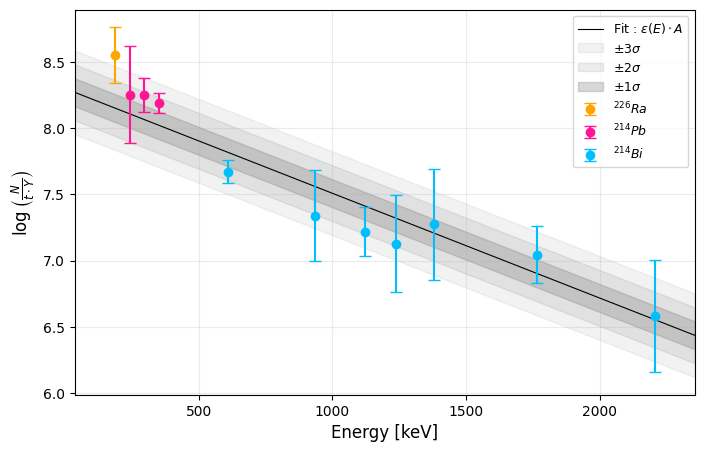

In [571]:

x = np.linspace(min(mu_kev)-150, max(mu_kev)+150, 10000)

plt.figure(figsize=(8,5))

bounds = ([0, 8.28],[1, 8.3])
p0 = [0.05, 8.29]
popt, cov = curve_fit(linear,mu_kev,np.log(Y), sigma=np.abs(sigma_logY) , p0 = p0, bounds = bounds)
m = popt[0]
q_prime = popt[1]

m_err = np.sqrt(np.diag(cov))[0]
q_prime_err =  np.sqrt(np.diag(cov))[1]

q = q_prime - np.log(A_max)
q_err = q_prime_err - 0.15 
print(q)
print(q_prime)

# Calcolo i valori di fit per il parametro q_prime ± n*sigma
fit_central = linear(x, popt[0], popt[1])
fit_p1 = linear(x, popt[0], popt[1] + q_prime_err)
fit_m1 = linear(x, popt[0], popt[1] - q_prime_err)
fit_p2 = linear(x, popt[0], popt[1] + 2*q_prime_err)
fit_m2 = linear(x, popt[0], popt[1] - 2*q_prime_err)
fit_p3 = linear(x, popt[0], popt[1] + 3*q_prime_err)
fit_m3 = linear(x, popt[0], popt[1] - 3*q_prime_err)

# Plot della curva centrale
plt.plot(x, fit_central, color='black', lw=0.8, label=r'Fit : $\varepsilon(E) \cdot A$')

# Riempio le bande di incertezza con grigi sempre più chiari
plt.fill_between(x, fit_m3, fit_p3, color='gray', alpha=0.1, label=r'$\pm 3\sigma$')
plt.fill_between(x, fit_m2, fit_p2, color='gray', alpha=0.15, label=r'$\pm 2\sigma$')
plt.fill_between(x, fit_m1, fit_p1, color='gray', alpha=0.3, label=r'$\pm 1\sigma$')
'''
# Linee tratteggiate per ±1σ, ±2σ, ±3σ (opzionale)
plt.plot(x, fit_p1, color='black', lw=0.75, ls='--', alpha=0.8)
plt.plot(x, fit_m1, color='black', lw=0.75, ls='--', alpha=0.8)
plt.plot(x, fit_p2, color='black', lw=0.75, ls=':', alpha=0.7)
plt.plot(x, fit_m2, color='black', lw=0.75, ls=':', alpha=0.7)
plt.plot(x, fit_p3, color='black', lw=0.75, ls='-.', alpha=0.6)
plt.plot(x, fit_m3, color='black', lw=0.75, ls='-.', alpha=0.6)
'''
# Errorbar per i dati
plt.errorbar(mu_kev[0], np.log(Y[0]), yerr=np.abs(sigma_logY[0])*10, fmt='o', color='orange', label=r'$^{226}Ra$', markersize=6, capsize=4)
plt.errorbar(mu_kev[1:4], np.log(Y[1:4]), yerr=np.abs(sigma_logY[1:4])*10, fmt='o', color='deeppink', label=r'$^{214}Pb$', markersize=6, capsize=4)
plt.errorbar(mu_kev[4:], np.log(Y[4:]), yerr=np.abs(sigma_logY[4:])*10, fmt='o', color='deepskyblue', label=r'$^{214}Bi$', markersize=6, capsize=4)

plt.xlabel("Energy [keV]", size=12)
plt.xlim(min(x), max(x))
plt.ylabel(r"$\log\left(\frac{N}{t \cdot Y}\right)$", size=12)
plt.grid(alpha=0.25)
plt.legend(fontsize=9)
plt.savefig("HPGe images/activity/Y_vs_E", dpi=300, bbox_inches='tight')
plt.show()


In [572]:
def eff_err(E_tot, m, q, m_err, q_err):
    eff = np.exp(linear(E_tot, m, q)) 
    d1 = -E_tot * m_err
    d2 = q_err
    return eff*np.sqrt(d1**2 + d2**2)

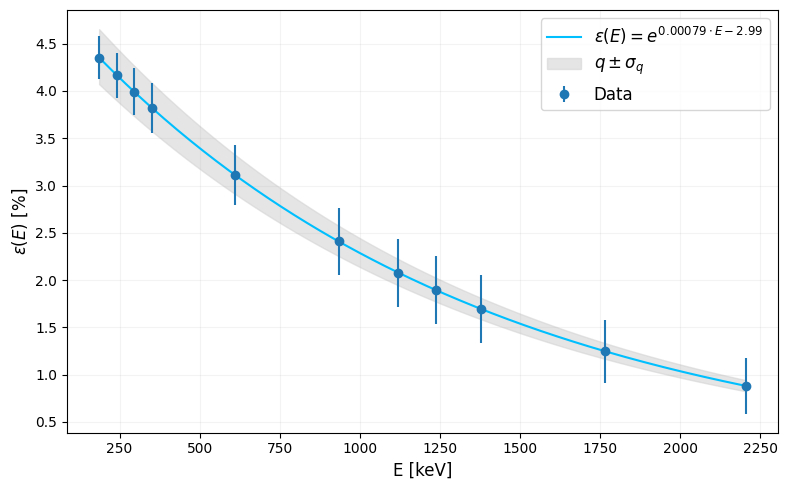

In [573]:
plt.figure(figsize = (8,5))

# Calcolo efficienza e incertezza
eff = np.exp(linear(E_tot, m, q)) * 100
eff_err_vals = eff_err(E_tot, m, q, m_err, q_err) * 100

# Plot dati con barre d'errore
plt.errorbar(E_tot, eff, yerr = eff_err_vals, fmt = 'o', label='Data')

# Range continuo per le curve
x = np.linspace(min(E_tot), max(E_tot), 200)
central = np.exp(linear(x, m, q)) * 100
upper = np.exp(linear(x, m, q + 1.5*q_err)) * 100
lower = np.exp(linear(x, m, q - 1.5*q_err)) * 100



# Curve centrale
plt.plot(x, central, color='deepskyblue', 
         label=rf'$\varepsilon(E) = e^{{{m:.5f} \cdot E {q:+.2f}}}$')
# Banda grigia di incertezza ±3σ
plt.fill_between(x, lower, upper, color='lightgray', alpha=0.58, label=r'$q \pm \sigma_q$')
plt.xlabel('E [keV]', size = 12)
plt.ylabel(r'$\varepsilon(E)$ [%]', size = 12)
plt.grid(alpha = 0.15)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig("HPGe images/activity/eff_curve", dpi=300, bbox_inches='tight')
plt.show()


In [574]:
def A_err(mu_kev, Y,N_U, N_U_err, m, q, m_err, q_err):
    dY = (Y/N_U)*N_U_err
    deff_1 = -mu_kev*np.exp(linear(mu_kev, m, q))*m_err
    deff_2 = np.exp(linear(mu_kev, m, q))*q_err

    return np.sqrt(dY**2 +deff_1**2 + deff_2**2)
    
    
    

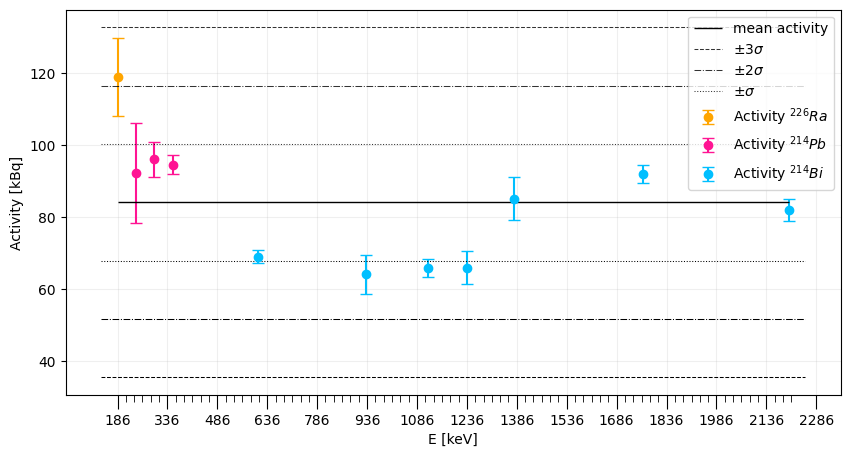

In [584]:

plt.figure(figsize=(10, 5))

A = np.array(Y) / np.exp(linear(mu_kev, m, q))
dA = A_err(mu_kev, Y, N_U, N_U_err, m, q, m_err, q_err)

plt.errorbar(mu_kev[0], A[0] / 1000, yerr=dA[0] / 10, fmt='o', color='orange', capsize=4, label=r'Activity $^{226}Ra$')
plt.errorbar(mu_kev[1:4], A[1:4] / 1000, yerr=dA[1:4] / 10, fmt='o', color='deeppink', capsize=4, label=r'Activity $^{214}Pb$')
plt.errorbar(mu_kev[4:], A[4:] / 1000, yerr=dA[4:] / 10, fmt='o', color='deepskyblue', capsize=4, label=r'Activity $^{214}Bi$')

plt.grid(alpha=0.2)

A_equilibrium = A
mean_activity = np.mean(A_equilibrium / 1000)
std_activity = np.std(A_equilibrium / 1000)

xmin, xmax = min(mu_kev), max(mu_kev)

plt.hlines(mean_activity, xmin, xmax, color='black', lw=1, label=r'mean activity')
plt.hlines(mean_activity + 3 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='--', label=r'$\pm 3 \sigma$')
plt.hlines(mean_activity - 3 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='--')
plt.hlines(mean_activity + 2 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='-.', label=r'$\pm 2 \sigma$')
plt.hlines(mean_activity - 2 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='-.')
plt.hlines(mean_activity + std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='dotted', label=r'$\pm \sigma$')
plt.hlines(mean_activity - std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='dotted')

plt.ylabel('Activity [kBq]')
plt.xlabel('E [keV]')

# Impostare tacchette sull'asse x
minor_ticks = np.arange(xmin, xmax + 25, 25)  # tacchette ogni 25 keV
major_ticks = np.arange(xmin, xmax + 150,150)  # tacchette con label ogni 100 keV

plt.gca().set_xticks(minor_ticks, minor=True)
plt.gca().set_xticks(major_ticks)
plt.gca().set_xticklabels([str(int(tick)) for tick in major_ticks])

plt.gca().tick_params(axis='x', which='minor', length=5)  # lunghezza tacchette minori
plt.gca().tick_params(axis='x', which='major', length=10)  # lunghezza tacchette maggiori

plt.legend(loc='upper right')
plt.savefig("HPGe images/activity/attivita_finali", dpi=300, bbox_inches='tight')
plt.show()

In [576]:
print(f'A equilibrio {np.mean(A_equilibrium/1000):.0f} kBq pm {np.std(A_equilibrium/1000):.0f}')
print(f'A Ra {(A[0]/1000):.0f} kBq pm ')
print(f'A Bi {np.mean(A_equilibrium[1:4]/1000):.0f} kBq pm {np.std(A_equilibrium[1:4]/1000):.0f}')
print(f'A Pb {np.mean(A_equilibrium[4:]/1000):.0f} kBq pm {np.std(A_equilibrium[4:]/1000):.0f}')




A equilibrio 81 kBq pm 13
A Ra 119 kBq pm 
A Bi 87 kBq pm 12
A Pb 76 kBq pm 11


In [577]:
m_sasso = 0.6*0.001 #kg

print(f'A equilibrio {np.mean(A_equilibrium/1000)/m_sasso:.0f} kBq/kg')
print(f'A Ra {(A[0]/1000)/m_sasso:.0f} kBq')
print(f'A Bi {np.mean(A_equilibrium[1:4]/1000)/m_sasso:.0f} kBq/kg')
print(f'A Pb {np.mean(A_equilibrium[4:]/1000)/m_sasso:.0f} kBq/kg')



A equilibrio 134424 kBq/kg
A Ra 198251 kBq
A Bi 144202 kBq/kg
A Pb 126298 kBq/kg


# background comparison


In [578]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_bkg = data[0].values

# correggo col dead time il background
t_live_b = 76747
t_real_b = 76752
# correggo subito per il tempo morto
D_b = 1-(t_live_b/t_real_b)

spectrum_bkg = spectrum_bkg/D_b

# normalizzo al tmepo dell'uranio
spectrum_bkg = spectrum_bkg*(t_real_u/ t_real_b)

In [579]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625
# correggo subito per il tempo morto
D_u = 1-(t_live_u/t_real_u)

spectrum_U = spectrum_U/D_u


In [580]:
# Load the spectrum data
file_path = "Bckg_OPEN.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_open = data[0].values

# correggo col dead time il background---> lo faccio subito in modod talr da avere già lo sesso spettro corretto ed avere la stessa risoluszione enrgetica. il dead time peggior la risoluzione
t_live_open = 58348
t_real_open = 58394
# correggo subito per il tempo morto
D_b = 1-(t_live_open/t_real_open)
# normalizzo anche al tempo pou corto dell'uranio
spectrum_open = spectrum_open/D_b
spectrum_open = spectrum_open*(t_real_u/ t_real_open)
spectrum_open[spectrum_open < 0] = 0 


In [ ]:
plt.figure(figsize=(15, 5))


chn = np.arange(len(spectrum_open))  # canali da 0 a N-1
bins = np.linspace(min(chn), max(chn), len(chn)+1)
counts, bin_edges, _ = plt.hist(chn, bins=bins, weights=spectrum_open, color = 'deepskyblue', label='Background (open shield)')



chn =  np.arange(len(spectrum_U))
bins =  np.linspace(min(chn), max(chn), len(chn), +1 )
counts, bin_edge, _ = plt.hist(chn, bins = bins, weights = spectrum_U,label = 'Sample spectrum' )
db = bin_edge[1]-bin_edge[0]


chn = np.arange(len(spectrum_bkg))
bins = np.linspace(min(chn), max(chn), len(chn)+1)
counts, bin_edges, _ = plt.hist(chn, bins=bins, weights=spectrum_bkg, color ='orange',label='Background (close shield)')



plt.yscale('log')
plt.ylim(100, 8e5)
plt.xticks(np.arange(0,max(chn),500), rotation = 45)

plt.xlim(0, max(chn))
db = bin_edges[1]-bin_edges[0]
plt.xlabel('Channel', size = 15)
plt.ylabel(f'Counts / {db:.0f} chn', size = 15)
plt.title('Background Spectrum Comparison', size = 15)
plt.legend( loc = 'upper right',fontsize = 13)
plt.grid(alpha = 0.25)
plt.savefig("HPGE open background/spettro_chn_op", dpi=300, bbox_inches='tight')

In [582]:

print(f'attività grezza background closed {np.sum(spectrum_bkg)/(t_real_u):.0f} cps')
print(f'attività grezza background open {np.sum(spectrum_open)/(t_real_u):.0f} cps')
print(f'attività grezza source {np.sum(spectrum_U)/(t_real_u):.0f} cps')

attività grezza background closed 15869 cps
attività grezza background open 48683 cps
attività grezza source 52471 cps


In [583]:
100*(15869/48683)

32.59659429369595